# Preprocess training  and test dataset

- make all letters lowercase for all ingredients
- removes extra whitespaces
- word stemming for ingredients
- remove certain words from ingredients
- remove numbers from ingredients
- remove certain special characters from ingredients
- remove useless adjectives from ingredients such as large, fat and low.
- remove the common ingredients that exist in all cuisines such as salt and water.

In [32]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from nltk.stem.wordnet import WordNetLemmatizer
import re
import itertools
import os.path

def remove_numbers(ingredient):    
    return [[re.sub("\d+", "", x) for x in y] for y in ingredient]

def remove_special_chars(ingredient):   
    ingredient = [[x.replace("-", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("&", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("'", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("''", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("%", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("!", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("(", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(")", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("/", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("/", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(",", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(".", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(u"\u2122", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(u"\u00AE", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(u"\u2019", " ") for x in y] for y in ingredient] 

    return ingredient
    
def make_lowercase(ingredient):    
    return [[x.lower() for x in y] for y in ingredient]

def remove_extra_whitespace(ingredient):    
    return [[re.sub( '\s+', ' ', x).strip() for x in y] for y in ingredient] 
    
    
def stem_words(ingredient):    
    lmtzr = WordNetLemmatizer()
    def word_by_word(strng):
        return " ".join(["".join(lmtzr.lemmatize(w)) for w in strng.split()])
    return [[word_by_word(x) for x in y] for y in ingredient] 
    
    
def remove_units(ingredient):    
    remove_list = ['g', 'lb', 's', 'n']
        
    def check_word(strng):
        
        s = strng.split()
        resw  = [word for word in s if word.lower() not in remove_list]
        
        return ' '.join(resw)

    return [[check_word(x) for x in y] for y in ingredient] 

- Read data into panda dataFrame.

In [33]:
import csv, os, pandas as pd, pathlib, pprint, json, numpy as np
import bagOfWords as bow
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
# Make sure json training json file exists

data_directory = os.path.join(os.getcwd(), "Dataset")
train_data_file_path = os.path.join(data_directory, "train.json")
test_data_file_path = os.path.join(data_directory, "test.json")
    
if(not pathlib.Path(train_data_file_path).is_file()):
    raise Exception("Missing train.json file in " + data_directory)

    
if(not pathlib.Path(test_data_file_path).is_file()):
    raise Exception("Missing test.json file in " + data_directory)

In [35]:
# Read JSON training data

with open(train_data_file_path, 'r') as f:
     trainData = pd.read_json(f)
f.closed

with open(test_data_file_path, 'r') as f:
     testData = pd.read_json(f)
f.closed

trainData.head()

cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian  22213                [water, vegetable oil, wheat, salt]
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...

# section 2 : preprosseing data:

- Change the text case : 
Data is often received in irregular formats. For example: ‘Milk’ & ‘milk’. Both mean the same thing but is represented in a different manner. Therefore, it is helpful to change the case of text. Either to upper or lower case. I changed to be lower case.

- Remove numbers from ingredients.
- Remove special chars such as -,&
- Remove extra whitespace
- Remove units such as 'g', 'lb', 's', 'n'
- stemming for ingredients.

In [36]:
trainData['ingredients'] = make_lowercase(trainData['ingredients'])
trainData['ingredients'] = remove_numbers(trainData['ingredients'])
trainData['ingredients'] = remove_special_chars(trainData['ingredients'])
trainData['ingredients'] = remove_extra_whitespace(trainData['ingredients'])
trainData['ingredients'] = remove_units(trainData['ingredients'])
trainData['ingredients'] = stem_words(trainData['ingredients'])


testData['ingredients'] = make_lowercase(testData['ingredients'])
testData['ingredients'] = remove_numbers(testData['ingredients'])
testData['ingredients'] = remove_special_chars(testData['ingredients'])
testData['ingredients'] = remove_extra_whitespace(testData['ingredients'])
testData['ingredients'] = remove_units(testData['ingredients'])
testData['ingredients'] = stem_words(testData['ingredients'])


# We can also create a word cloud to check the most frequent terms. It is easy to build and gives an enhanced understanding of ingredients in this data. 

I used NLTK library in order to retrieve only the adjective words in the list of ingredients because there will be some adjectives without strong meaning such as large, low and fat. On the other hand, there will be some adjective words with a strong meaning such as Mexican, Italian, and Chinese which may mean the type of cuisine.

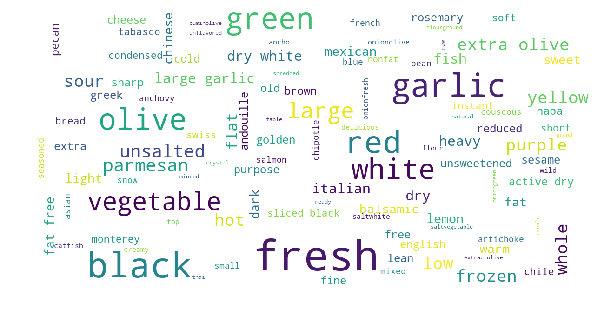

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import nltk


text=""
i =0 
for ingredients_list in trainData['ingredients']:
    i= i+1
    text +=",".join(str(x) for x in ingredients_list)
    if i==1500:  
        break

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=30, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
ingredients_list = text.split(",")
text =''
for ingredient in ingredients_list:
    ingredient = nltk.word_tokenize(ingredient)
    tagged = nltk.tag.pos_tag(ingredient)
    for item in tagged:
        if item[1]== 'JJ':
            text = text +" "+item[0]
show_wordcloud(text)

- and also do the same for test dataset.

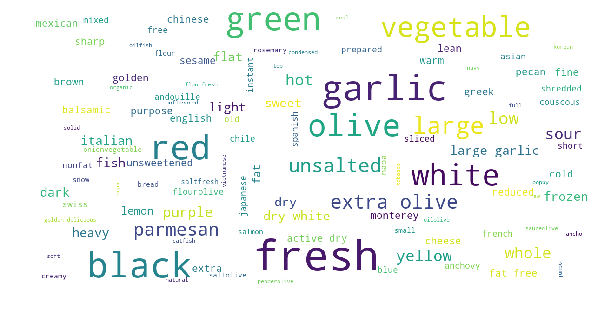

In [38]:
text=""
i =0 
ingredients_list = []
for ingredients_list in testData['ingredients']:
    i= i+1
    text +=",".join(str(x) for x in ingredients_list)
    if i==1500:  
        break
        
ingredients_list = text.split(",")
text =''
for ingredient in ingredients_list:
    ingredient = nltk.word_tokenize(ingredient)
    tagged = nltk.tag.pos_tag(ingredient)
    for item in tagged:
        if item[1]== 'JJ':
            text = text +" "+item[0]
show_wordcloud(text)

Advanced data cleaning could be happened by removing adjective terms that do not have a strong meaning such as large, fresh and fat. 

In [39]:
stop_adjective_words = ['large','low','fat','free','skim','fresh','sliced','light','flat']
ingredients = []

#trainData['ingredients']
i =1
for ingredients_single_cuisine in trainData['ingredients'] :
    temp_list=[]
    for item in ingredients_single_cuisine:
        if ' ' in item:
            ing_single_list = item.split(' ')
            temp = ''
            for single_term in ing_single_list:
                if single_term in stop_adjective_words:
                    print("word has been removed form recipe ",i,"= ",single_term)
                else:
                    temp =temp+" "+single_term
                    temp=temp.strip()
            temp_list.append(temp)
        else:
            temp_list.append(item)
    ingredients.append(temp_list)
    i =i +1

word has been removed form recipe  6 =  fresh
word has been removed form recipe  7 =  flat
word has been removed form recipe  9 =  fresh
word has been removed form recipe  9 =  fresh
word has been removed form recipe  10 =  fresh
word has been removed form recipe  10 =  flat
word has been removed form recipe  12 =  low
word has been removed form recipe  12 =  fresh
word has been removed form recipe  13 =  fresh
word has been removed form recipe  13 =  flat
word has been removed form recipe  14 =  fresh
word has been removed form recipe  15 =  fresh
word has been removed form recipe  15 =  fat
word has been removed form recipe  15 =  free
word has been removed form recipe  15 =  fresh
word has been removed form recipe  15 =  fat
word has been removed form recipe  15 =  free
word has been removed form recipe  20 =  sliced
word has been removed form recipe  20 =  fresh
word has been removed form recipe  21 =  fresh
word has been removed form recipe  21 =  fresh
word has been removed form 

word has been removed form recipe  595 =  free
word has been removed form recipe  596 =  fresh
word has been removed form recipe  596 =  fresh
word has been removed form recipe  597 =  fresh
word has been removed form recipe  597 =  large
word has been removed form recipe  598 =  light
word has been removed form recipe  599 =  sliced
word has been removed form recipe  600 =  flat
word has been removed form recipe  604 =  large
word has been removed form recipe  604 =  fresh
word has been removed form recipe  608 =  light
word has been removed form recipe  611 =  fresh
word has been removed form recipe  612 =  fresh
word has been removed form recipe  613 =  large
word has been removed form recipe  616 =  fresh
word has been removed form recipe  617 =  skim
word has been removed form recipe  617 =  fresh
word has been removed form recipe  618 =  large
word has been removed form recipe  618 =  fresh
word has been removed form recipe  619 =  fresh
word has been removed form recipe  619 =  

word has been removed form recipe  1035 =  fresh
word has been removed form recipe  1037 =  light
word has been removed form recipe  1038 =  flat
word has been removed form recipe  1039 =  fresh
word has been removed form recipe  1039 =  fresh
word has been removed form recipe  1039 =  sliced
word has been removed form recipe  1040 =  fresh
word has been removed form recipe  1041 =  fresh
word has been removed form recipe  1044 =  fresh
word has been removed form recipe  1044 =  fresh
word has been removed form recipe  1048 =  fresh
word has been removed form recipe  1048 =  fresh
word has been removed form recipe  1052 =  light
word has been removed form recipe  1052 =  large
word has been removed form recipe  1054 =  fresh
word has been removed form recipe  1054 =  fresh
word has been removed form recipe  1054 =  fresh
word has been removed form recipe  1057 =  fresh
word has been removed form recipe  1058 =  large
word has been removed form recipe  1060 =  fresh
word has been remove

word has been removed form recipe  1445 =  fresh
word has been removed form recipe  1446 =  large
word has been removed form recipe  1448 =  fresh
word has been removed form recipe  1448 =  fresh
word has been removed form recipe  1450 =  fresh
word has been removed form recipe  1450 =  low
word has been removed form recipe  1453 =  fresh
word has been removed form recipe  1455 =  fat
word has been removed form recipe  1455 =  free
word has been removed form recipe  1455 =  flat
word has been removed form recipe  1455 =  sliced
word has been removed form recipe  1459 =  fresh
word has been removed form recipe  1459 =  fresh
word has been removed form recipe  1459 =  fresh
word has been removed form recipe  1460 =  fresh
word has been removed form recipe  1461 =  fresh
word has been removed form recipe  1465 =  sliced
word has been removed form recipe  1467 =  large
word has been removed form recipe  1467 =  flat
word has been removed form recipe  1467 =  low
word has been removed form 

word has been removed form recipe  1833 =  fresh
word has been removed form recipe  1834 =  light
word has been removed form recipe  1835 =  fresh
word has been removed form recipe  1836 =  sliced
word has been removed form recipe  1837 =  low
word has been removed form recipe  1838 =  fresh
word has been removed form recipe  1838 =  fresh
word has been removed form recipe  1839 =  large
word has been removed form recipe  1840 =  large
word has been removed form recipe  1843 =  fresh
word has been removed form recipe  1844 =  large
word has been removed form recipe  1847 =  fresh
word has been removed form recipe  1848 =  large
word has been removed form recipe  1848 =  flat
word has been removed form recipe  1849 =  fresh
word has been removed form recipe  1850 =  large
word has been removed form recipe  1852 =  large
word has been removed form recipe  1852 =  fresh
word has been removed form recipe  1855 =  fresh
word has been removed form recipe  1858 =  low
word has been removed fo

word has been removed form recipe  2241 =  large
word has been removed form recipe  2241 =  fresh
word has been removed form recipe  2245 =  fat
word has been removed form recipe  2245 =  low
word has been removed form recipe  2245 =  fat
word has been removed form recipe  2245 =  fat
word has been removed form recipe  2247 =  fresh
word has been removed form recipe  2249 =  light
word has been removed form recipe  2249 =  fresh
word has been removed form recipe  2249 =  fat
word has been removed form recipe  2249 =  free
word has been removed form recipe  2249 =  flat
word has been removed form recipe  2250 =  light
word has been removed form recipe  2252 =  fresh
word has been removed form recipe  2253 =  large
word has been removed form recipe  2256 =  fresh
word has been removed form recipe  2257 =  fresh
word has been removed form recipe  2260 =  fresh
word has been removed form recipe  2263 =  light
word has been removed form recipe  2264 =  large
word has been removed form recip

word has been removed form recipe  2676 =  low
word has been removed form recipe  2676 =  fat
word has been removed form recipe  2676 =  fat
word has been removed form recipe  2676 =  free
word has been removed form recipe  2678 =  large
word has been removed form recipe  2678 =  large
word has been removed form recipe  2680 =  fresh
word has been removed form recipe  2681 =  fresh
word has been removed form recipe  2681 =  fresh
word has been removed form recipe  2684 =  fresh
word has been removed form recipe  2684 =  large
word has been removed form recipe  2684 =  fresh
word has been removed form recipe  2689 =  flat
word has been removed form recipe  2689 =  fresh
word has been removed form recipe  2689 =  fresh
word has been removed form recipe  2693 =  fresh
word has been removed form recipe  2699 =  fresh
word has been removed form recipe  2700 =  fresh
word has been removed form recipe  2700 =  fresh
word has been removed form recipe  2700 =  fresh
word has been removed form r

word has been removed form recipe  3102 =  low
word has been removed form recipe  3102 =  fresh
word has been removed form recipe  3102 =  light
word has been removed form recipe  3104 =  fresh
word has been removed form recipe  3105 =  sliced
word has been removed form recipe  3107 =  fresh
word has been removed form recipe  3108 =  fresh
word has been removed form recipe  3111 =  fresh
word has been removed form recipe  3111 =  fresh
word has been removed form recipe  3113 =  fat
word has been removed form recipe  3113 =  free
word has been removed form recipe  3114 =  light
word has been removed form recipe  3116 =  fresh
word has been removed form recipe  3116 =  fresh
word has been removed form recipe  3119 =  large
word has been removed form recipe  3119 =  fresh
word has been removed form recipe  3120 =  flat
word has been removed form recipe  3120 =  large
word has been removed form recipe  3122 =  large
word has been removed form recipe  3124 =  fresh
word has been removed for

word has been removed form recipe  3434 =  fresh
word has been removed form recipe  3435 =  free
word has been removed form recipe  3436 =  flat
word has been removed form recipe  3437 =  fresh
word has been removed form recipe  3438 =  fat
word has been removed form recipe  3440 =  fresh
word has been removed form recipe  3441 =  fresh
word has been removed form recipe  3441 =  fresh
word has been removed form recipe  3442 =  fresh
word has been removed form recipe  3442 =  fresh
word has been removed form recipe  3443 =  large
word has been removed form recipe  3443 =  large
word has been removed form recipe  3443 =  fresh
word has been removed form recipe  3447 =  fresh
word has been removed form recipe  3447 =  fresh
word has been removed form recipe  3447 =  flat
word has been removed form recipe  3449 =  fresh
word has been removed form recipe  3451 =  flat
word has been removed form recipe  3452 =  fresh
word has been removed form recipe  3452 =  fresh
word has been removed form

word has been removed form recipe  3843 =  fresh
word has been removed form recipe  3843 =  fresh
word has been removed form recipe  3844 =  large
word has been removed form recipe  3844 =  low
word has been removed form recipe  3846 =  large
word has been removed form recipe  3846 =  sliced
word has been removed form recipe  3846 =  light
word has been removed form recipe  3847 =  fresh
word has been removed form recipe  3847 =  fresh
word has been removed form recipe  3847 =  fresh
word has been removed form recipe  3849 =  fresh
word has been removed form recipe  3850 =  fresh
word has been removed form recipe  3855 =  large
word has been removed form recipe  3856 =  flat
word has been removed form recipe  3856 =  fresh
word has been removed form recipe  3857 =  light
word has been removed form recipe  3858 =  large
word has been removed form recipe  3858 =  large
word has been removed form recipe  3865 =  flat
word has been removed form recipe  3865 =  fresh
word has been removed f

word has been removed form recipe  4209 =  fresh
word has been removed form recipe  4209 =  low
word has been removed form recipe  4211 =  fresh
word has been removed form recipe  4217 =  fresh
word has been removed form recipe  4218 =  large
word has been removed form recipe  4227 =  low
word has been removed form recipe  4227 =  fresh
word has been removed form recipe  4228 =  fresh
word has been removed form recipe  4229 =  fresh
word has been removed form recipe  4231 =  skim
word has been removed form recipe  4232 =  fresh
word has been removed form recipe  4236 =  fresh
word has been removed form recipe  4237 =  large
word has been removed form recipe  4239 =  fresh
word has been removed form recipe  4239 =  fresh
word has been removed form recipe  4242 =  fresh
word has been removed form recipe  4244 =  fat
word has been removed form recipe  4244 =  fresh
word has been removed form recipe  4246 =  flat
word has been removed form recipe  4249 =  sliced
word has been removed form 

word has been removed form recipe  4647 =  fresh
word has been removed form recipe  4650 =  fresh
word has been removed form recipe  4651 =  fresh
word has been removed form recipe  4651 =  fresh
word has been removed form recipe  4651 =  fresh
word has been removed form recipe  4654 =  large
word has been removed form recipe  4654 =  low
word has been removed form recipe  4654 =  fat
word has been removed form recipe  4660 =  large
word has been removed form recipe  4661 =  fat
word has been removed form recipe  4663 =  sliced
word has been removed form recipe  4663 =  fat
word has been removed form recipe  4664 =  large
word has been removed form recipe  4666 =  fresh
word has been removed form recipe  4667 =  fresh
word has been removed form recipe  4668 =  flat
word has been removed form recipe  4668 =  large
word has been removed form recipe  4669 =  fresh
word has been removed form recipe  4670 =  fresh
word has been removed form recipe  4670 =  fresh
word has been removed form r

word has been removed form recipe  5063 =  fresh
word has been removed form recipe  5063 =  fresh
word has been removed form recipe  5063 =  large
word has been removed form recipe  5064 =  fresh
word has been removed form recipe  5065 =  fat
word has been removed form recipe  5068 =  fresh
word has been removed form recipe  5069 =  large
word has been removed form recipe  5071 =  fat
word has been removed form recipe  5071 =  free
word has been removed form recipe  5071 =  fresh
word has been removed form recipe  5073 =  fresh
word has been removed form recipe  5074 =  large
word has been removed form recipe  5076 =  large
word has been removed form recipe  5076 =  fresh
word has been removed form recipe  5080 =  fresh
word has been removed form recipe  5080 =  fresh
word has been removed form recipe  5084 =  fresh
word has been removed form recipe  5084 =  low
word has been removed form recipe  5085 =  fresh
word has been removed form recipe  5086 =  fresh
word has been removed form 

word has been removed form recipe  5553 =  fresh
word has been removed form recipe  5553 =  light
word has been removed form recipe  5553 =  fresh
word has been removed form recipe  5554 =  sliced
word has been removed form recipe  5558 =  fat
word has been removed form recipe  5558 =  free
word has been removed form recipe  5558 =  fresh
word has been removed form recipe  5561 =  fat
word has been removed form recipe  5561 =  free
word has been removed form recipe  5561 =  large
word has been removed form recipe  5562 =  low
word has been removed form recipe  5569 =  fresh
word has been removed form recipe  5569 =  fresh
word has been removed form recipe  5570 =  flat
word has been removed form recipe  5573 =  large
word has been removed form recipe  5576 =  fresh
word has been removed form recipe  5576 =  fresh
word has been removed form recipe  5576 =  fresh
word has been removed form recipe  5576 =  fresh
word has been removed form recipe  5576 =  fresh
word has been removed form r

word has been removed form recipe  6017 =  low
word has been removed form recipe  6017 =  fat
word has been removed form recipe  6017 =  fresh
word has been removed form recipe  6018 =  fresh
word has been removed form recipe  6019 =  fat
word has been removed form recipe  6019 =  large
word has been removed form recipe  6019 =  fat
word has been removed form recipe  6022 =  fat
word has been removed form recipe  6022 =  free
word has been removed form recipe  6023 =  fresh
word has been removed form recipe  6026 =  large
word has been removed form recipe  6032 =  fresh
word has been removed form recipe  6032 =  large
word has been removed form recipe  6032 =  flat
word has been removed form recipe  6033 =  fat
word has been removed form recipe  6034 =  fresh
word has been removed form recipe  6035 =  fresh
word has been removed form recipe  6039 =  fresh
word has been removed form recipe  6039 =  fresh
word has been removed form recipe  6040 =  large
word has been removed form recipe 

word has been removed form recipe  6403 =  large
word has been removed form recipe  6405 =  fresh
word has been removed form recipe  6407 =  sliced
word has been removed form recipe  6407 =  sliced
word has been removed form recipe  6407 =  low
word has been removed form recipe  6407 =  fresh
word has been removed form recipe  6411 =  large
word has been removed form recipe  6411 =  fresh
word has been removed form recipe  6411 =  fresh
word has been removed form recipe  6411 =  low
word has been removed form recipe  6411 =  fat
word has been removed form recipe  6412 =  fresh
word has been removed form recipe  6412 =  skim
word has been removed form recipe  6412 =  large
word has been removed form recipe  6416 =  low
word has been removed form recipe  6416 =  fresh
word has been removed form recipe  6418 =  large
word has been removed form recipe  6418 =  large
word has been removed form recipe  6422 =  sliced
word has been removed form recipe  6425 =  flat
word has been removed form 

word has been removed form recipe  6746 =  large
word has been removed form recipe  6746 =  fat
word has been removed form recipe  6746 =  fresh
word has been removed form recipe  6747 =  fresh
word has been removed form recipe  6747 =  light
word has been removed form recipe  6748 =  light
word has been removed form recipe  6749 =  fat
word has been removed form recipe  6749 =  free
word has been removed form recipe  6749 =  large
word has been removed form recipe  6753 =  fresh
word has been removed form recipe  6753 =  low
word has been removed form recipe  6753 =  fat
word has been removed form recipe  6755 =  fresh
word has been removed form recipe  6755 =  fat
word has been removed form recipe  6760 =  fat
word has been removed form recipe  6760 =  fresh
word has been removed form recipe  6760 =  fresh
word has been removed form recipe  6764 =  fresh
word has been removed form recipe  6764 =  fresh
word has been removed form recipe  6764 =  fresh
word has been removed form recipe

word has been removed form recipe  7217 =  fresh
word has been removed form recipe  7219 =  skim
word has been removed form recipe  7220 =  fresh
word has been removed form recipe  7221 =  large
word has been removed form recipe  7221 =  fresh
word has been removed form recipe  7221 =  fresh
word has been removed form recipe  7227 =  low
word has been removed form recipe  7227 =  fresh
word has been removed form recipe  7227 =  fresh
word has been removed form recipe  7228 =  large
word has been removed form recipe  7228 =  large
word has been removed form recipe  7229 =  fresh
word has been removed form recipe  7232 =  fresh
word has been removed form recipe  7232 =  fresh
word has been removed form recipe  7235 =  flat
word has been removed form recipe  7235 =  fresh
word has been removed form recipe  7238 =  fresh
word has been removed form recipe  7239 =  fresh
word has been removed form recipe  7239 =  fresh
word has been removed form recipe  7239 =  fresh
word has been removed fo

word has been removed form recipe  7647 =  fresh
word has been removed form recipe  7649 =  light
word has been removed form recipe  7649 =  large
word has been removed form recipe  7651 =  light
word has been removed form recipe  7652 =  fresh
word has been removed form recipe  7653 =  fresh
word has been removed form recipe  7653 =  fresh
word has been removed form recipe  7658 =  light
word has been removed form recipe  7659 =  fresh
word has been removed form recipe  7659 =  fresh
word has been removed form recipe  7661 =  low
word has been removed form recipe  7661 =  fat
word has been removed form recipe  7661 =  fresh
word has been removed form recipe  7662 =  low
word has been removed form recipe  7662 =  fresh
word has been removed form recipe  7662 =  fresh
word has been removed form recipe  7663 =  large
word has been removed form recipe  7663 =  fresh
word has been removed form recipe  7663 =  fresh
word has been removed form recipe  7663 =  fresh
word has been removed form

word has been removed form recipe  8080 =  fresh
word has been removed form recipe  8080 =  light
word has been removed form recipe  8082 =  large
word has been removed form recipe  8085 =  fresh
word has been removed form recipe  8085 =  fresh
word has been removed form recipe  8086 =  skim
word has been removed form recipe  8086 =  fresh
word has been removed form recipe  8087 =  fresh
word has been removed form recipe  8087 =  fresh
word has been removed form recipe  8087 =  fresh
word has been removed form recipe  8089 =  large
word has been removed form recipe  8093 =  fresh
word has been removed form recipe  8094 =  fresh
word has been removed form recipe  8094 =  fresh
word has been removed form recipe  8097 =  fresh
word has been removed form recipe  8100 =  fresh
word has been removed form recipe  8101 =  fresh
word has been removed form recipe  8105 =  light
word has been removed form recipe  8107 =  fresh
word has been removed form recipe  8107 =  large
word has been removed

word has been removed form recipe  8552 =  fresh
word has been removed form recipe  8553 =  fat
word has been removed form recipe  8553 =  free
word has been removed form recipe  8555 =  fresh
word has been removed form recipe  8555 =  sliced
word has been removed form recipe  8556 =  fresh
word has been removed form recipe  8556 =  low
word has been removed form recipe  8556 =  flat
word has been removed form recipe  8557 =  flat
word has been removed form recipe  8558 =  fresh
word has been removed form recipe  8558 =  large
word has been removed form recipe  8558 =  fresh
word has been removed form recipe  8559 =  fresh
word has been removed form recipe  8560 =  fresh
word has been removed form recipe  8563 =  large
word has been removed form recipe  8563 =  fresh
word has been removed form recipe  8563 =  low
word has been removed form recipe  8563 =  fat
word has been removed form recipe  8566 =  fresh
word has been removed form recipe  8568 =  fresh
word has been removed form rec

word has been removed form recipe  8954 =  fresh
word has been removed form recipe  8958 =  fresh
word has been removed form recipe  8958 =  fresh
word has been removed form recipe  8958 =  fresh
word has been removed form recipe  8958 =  fresh
word has been removed form recipe  8959 =  fresh
word has been removed form recipe  8965 =  low
word has been removed form recipe  8966 =  fresh
word has been removed form recipe  8971 =  light
word has been removed form recipe  8972 =  large
word has been removed form recipe  8980 =  fresh
word has been removed form recipe  8982 =  fresh
word has been removed form recipe  8987 =  large
word has been removed form recipe  8987 =  fresh
word has been removed form recipe  8988 =  fresh
word has been removed form recipe  8992 =  fresh
word has been removed form recipe  8992 =  large
word has been removed form recipe  8993 =  sliced
word has been removed form recipe  8997 =  large
word has been removed form recipe  8997 =  large
word has been removed

word has been removed form recipe  9338 =  fresh
word has been removed form recipe  9338 =  large
word has been removed form recipe  9339 =  sliced
word has been removed form recipe  9339 =  low
word has been removed form recipe  9342 =  fresh
word has been removed form recipe  9342 =  fat
word has been removed form recipe  9346 =  sliced
word has been removed form recipe  9351 =  fresh
word has been removed form recipe  9351 =  fresh
word has been removed form recipe  9352 =  large
word has been removed form recipe  9353 =  low
word has been removed form recipe  9354 =  sliced
word has been removed form recipe  9355 =  low
word has been removed form recipe  9356 =  low
word has been removed form recipe  9356 =  fat
word has been removed form recipe  9356 =  large
word has been removed form recipe  9357 =  sliced
word has been removed form recipe  9359 =  flat
word has been removed form recipe  9360 =  fresh
word has been removed form recipe  9361 =  fresh
word has been removed form re

word has been removed form recipe  9782 =  fresh
word has been removed form recipe  9783 =  fresh
word has been removed form recipe  9785 =  large
word has been removed form recipe  9786 =  fresh
word has been removed form recipe  9787 =  large
word has been removed form recipe  9787 =  fresh
word has been removed form recipe  9788 =  low
word has been removed form recipe  9789 =  large
word has been removed form recipe  9791 =  fresh
word has been removed form recipe  9792 =  fresh
word has been removed form recipe  9795 =  large
word has been removed form recipe  9795 =  large
word has been removed form recipe  9795 =  flat
word has been removed form recipe  9798 =  large
word has been removed form recipe  9798 =  fresh
word has been removed form recipe  9799 =  fat
word has been removed form recipe  9799 =  free
word has been removed form recipe  9799 =  fresh
word has been removed form recipe  9802 =  large
word has been removed form recipe  9803 =  large
word has been removed form

word has been removed form recipe  10168 =  fresh
word has been removed form recipe  10169 =  fresh
word has been removed form recipe  10169 =  large
word has been removed form recipe  10169 =  fresh
word has been removed form recipe  10170 =  fresh
word has been removed form recipe  10170 =  fresh
word has been removed form recipe  10171 =  fresh
word has been removed form recipe  10172 =  fresh
word has been removed form recipe  10172 =  large
word has been removed form recipe  10173 =  fresh
word has been removed form recipe  10176 =  fresh
word has been removed form recipe  10177 =  fresh
word has been removed form recipe  10177 =  fresh
word has been removed form recipe  10177 =  low
word has been removed form recipe  10179 =  fresh
word has been removed form recipe  10179 =  low
word has been removed form recipe  10180 =  fresh
word has been removed form recipe  10185 =  fresh
word has been removed form recipe  10185 =  fresh
word has been removed form recipe  10187 =  fresh
word

word has been removed form recipe  10549 =  flat
word has been removed form recipe  10549 =  fresh
word has been removed form recipe  10549 =  fresh
word has been removed form recipe  10552 =  fresh
word has been removed form recipe  10554 =  fresh
word has been removed form recipe  10558 =  fresh
word has been removed form recipe  10558 =  fresh
word has been removed form recipe  10559 =  light
word has been removed form recipe  10559 =  low
word has been removed form recipe  10559 =  fat
word has been removed form recipe  10560 =  fresh
word has been removed form recipe  10563 =  low
word has been removed form recipe  10566 =  fresh
word has been removed form recipe  10566 =  fresh
word has been removed form recipe  10567 =  large
word has been removed form recipe  10567 =  flat
word has been removed form recipe  10569 =  fresh
word has been removed form recipe  10575 =  fresh
word has been removed form recipe  10576 =  large
word has been removed form recipe  10578 =  fresh
word has

word has been removed form recipe  10957 =  fresh
word has been removed form recipe  10959 =  large
word has been removed form recipe  10960 =  fresh
word has been removed form recipe  10963 =  low
word has been removed form recipe  10963 =  fat
word has been removed form recipe  10964 =  fresh
word has been removed form recipe  10964 =  fresh
word has been removed form recipe  10966 =  low
word has been removed form recipe  10966 =  fat
word has been removed form recipe  10971 =  fat
word has been removed form recipe  10971 =  free
word has been removed form recipe  10973 =  fresh
word has been removed form recipe  10974 =  low
word has been removed form recipe  10974 =  fresh
word has been removed form recipe  10974 =  flat
word has been removed form recipe  10976 =  flat
word has been removed form recipe  10978 =  fresh
word has been removed form recipe  10984 =  skim
word has been removed form recipe  10989 =  fresh
word has been removed form recipe  10989 =  fresh
word has been re

word has been removed form recipe  11405 =  skim
word has been removed form recipe  11406 =  fresh
word has been removed form recipe  11409 =  fresh
word has been removed form recipe  11410 =  large
word has been removed form recipe  11410 =  fresh
word has been removed form recipe  11410 =  low
word has been removed form recipe  11410 =  fat
word has been removed form recipe  11411 =  light
word has been removed form recipe  11411 =  fresh
word has been removed form recipe  11413 =  fresh
word has been removed form recipe  11416 =  sliced
word has been removed form recipe  11417 =  large
word has been removed form recipe  11418 =  low
word has been removed form recipe  11419 =  large
word has been removed form recipe  11420 =  fresh
word has been removed form recipe  11421 =  light
word has been removed form recipe  11421 =  fat
word has been removed form recipe  11421 =  free
word has been removed form recipe  11421 =  fresh
word has been removed form recipe  11421 =  fresh
word has 

word has been removed form recipe  11859 =  fresh
word has been removed form recipe  11860 =  flat
word has been removed form recipe  11861 =  fresh
word has been removed form recipe  11861 =  fresh
word has been removed form recipe  11861 =  fresh
word has been removed form recipe  11865 =  fresh
word has been removed form recipe  11866 =  large
word has been removed form recipe  11866 =  light
word has been removed form recipe  11867 =  large
word has been removed form recipe  11867 =  large
word has been removed form recipe  11868 =  light
word has been removed form recipe  11869 =  fresh
word has been removed form recipe  11869 =  low
word has been removed form recipe  11871 =  large
word has been removed form recipe  11871 =  fresh
word has been removed form recipe  11871 =  light
word has been removed form recipe  11871 =  fat
word has been removed form recipe  11871 =  free
word has been removed form recipe  11871 =  fresh
word has been removed form recipe  11872 =  large
word h

word has been removed form recipe  12275 =  large
word has been removed form recipe  12275 =  light
word has been removed form recipe  12279 =  fresh
word has been removed form recipe  12280 =  fat
word has been removed form recipe  12280 =  free
word has been removed form recipe  12280 =  fat
word has been removed form recipe  12280 =  fresh
word has been removed form recipe  12286 =  fresh
word has been removed form recipe  12288 =  fresh
word has been removed form recipe  12288 =  fresh
word has been removed form recipe  12289 =  fresh
word has been removed form recipe  12291 =  fresh
word has been removed form recipe  12291 =  fresh
word has been removed form recipe  12292 =  large
word has been removed form recipe  12293 =  flat
word has been removed form recipe  12296 =  low
word has been removed form recipe  12300 =  fresh
word has been removed form recipe  12300 =  fresh
word has been removed form recipe  12300 =  fresh
word has been removed form recipe  12305 =  fresh
word has

word has been removed form recipe  12632 =  large
word has been removed form recipe  12633 =  large
word has been removed form recipe  12638 =  light
word has been removed form recipe  12641 =  fresh
word has been removed form recipe  12641 =  fresh
word has been removed form recipe  12641 =  fresh
word has been removed form recipe  12647 =  low
word has been removed form recipe  12648 =  large
word has been removed form recipe  12648 =  fresh
word has been removed form recipe  12652 =  fresh
word has been removed form recipe  12655 =  fresh
word has been removed form recipe  12658 =  fresh
word has been removed form recipe  12658 =  fat
word has been removed form recipe  12658 =  free
word has been removed form recipe  12661 =  fresh
word has been removed form recipe  12661 =  fat
word has been removed form recipe  12661 =  free
word has been removed form recipe  12662 =  fresh
word has been removed form recipe  12662 =  fat
word has been removed form recipe  12662 =  fresh
word has b

word has been removed form recipe  13032 =  fresh
word has been removed form recipe  13032 =  fresh
word has been removed form recipe  13034 =  light
word has been removed form recipe  13034 =  large
word has been removed form recipe  13035 =  fresh
word has been removed form recipe  13035 =  large
word has been removed form recipe  13036 =  large
word has been removed form recipe  13037 =  sliced
word has been removed form recipe  13037 =  fresh
word has been removed form recipe  13037 =  fresh
word has been removed form recipe  13038 =  fresh
word has been removed form recipe  13038 =  fat
word has been removed form recipe  13038 =  free
word has been removed form recipe  13041 =  fresh
word has been removed form recipe  13041 =  fresh
word has been removed form recipe  13042 =  low
word has been removed form recipe  13042 =  fat
word has been removed form recipe  13042 =  fresh
word has been removed form recipe  13043 =  low
word has been removed form recipe  13045 =  fresh
word has

word has been removed form recipe  13450 =  fresh
word has been removed form recipe  13453 =  fresh
word has been removed form recipe  13453 =  flat
word has been removed form recipe  13453 =  fresh
word has been removed form recipe  13454 =  flat
word has been removed form recipe  13457 =  sliced
word has been removed form recipe  13458 =  fresh
word has been removed form recipe  13458 =  fresh
word has been removed form recipe  13458 =  fresh
word has been removed form recipe  13462 =  large
word has been removed form recipe  13464 =  skim
word has been removed form recipe  13465 =  fresh
word has been removed form recipe  13465 =  fresh
word has been removed form recipe  13466 =  fat
word has been removed form recipe  13466 =  free
word has been removed form recipe  13466 =  sliced
word has been removed form recipe  13466 =  fresh
word has been removed form recipe  13466 =  fat
word has been removed form recipe  13467 =  low
word has been removed form recipe  13467 =  fresh
word has

word has been removed form recipe  13885 =  fresh
word has been removed form recipe  13885 =  fresh
word has been removed form recipe  13892 =  fat
word has been removed form recipe  13892 =  fresh
word has been removed form recipe  13893 =  fresh
word has been removed form recipe  13893 =  flat
word has been removed form recipe  13894 =  large
word has been removed form recipe  13895 =  skim
word has been removed form recipe  13895 =  fresh
word has been removed form recipe  13897 =  fresh
word has been removed form recipe  13897 =  fresh
word has been removed form recipe  13897 =  low
word has been removed form recipe  13898 =  low
word has been removed form recipe  13898 =  fat
word has been removed form recipe  13898 =  large
word has been removed form recipe  13906 =  fresh
word has been removed form recipe  13907 =  fresh
word has been removed form recipe  13907 =  fresh
word has been removed form recipe  13907 =  fresh
word has been removed form recipe  13909 =  fresh
word has b

word has been removed form recipe  14385 =  low
word has been removed form recipe  14387 =  fresh
word has been removed form recipe  14389 =  fresh
word has been removed form recipe  14389 =  low
word has been removed form recipe  14394 =  large
word has been removed form recipe  14397 =  fresh
word has been removed form recipe  14400 =  low
word has been removed form recipe  14402 =  fresh
word has been removed form recipe  14403 =  fresh
word has been removed form recipe  14406 =  fresh
word has been removed form recipe  14409 =  fresh
word has been removed form recipe  14410 =  large
word has been removed form recipe  14410 =  fresh
word has been removed form recipe  14414 =  fresh
word has been removed form recipe  14415 =  fresh
word has been removed form recipe  14415 =  fresh
word has been removed form recipe  14415 =  fresh
word has been removed form recipe  14415 =  fresh
word has been removed form recipe  14416 =  light
word has been removed form recipe  14423 =  fresh
word h

word has been removed form recipe  14818 =  fresh
word has been removed form recipe  14818 =  sliced
word has been removed form recipe  14819 =  low
word has been removed form recipe  14819 =  large
word has been removed form recipe  14822 =  fat
word has been removed form recipe  14822 =  free
word has been removed form recipe  14822 =  fresh
word has been removed form recipe  14823 =  fat
word has been removed form recipe  14823 =  free
word has been removed form recipe  14823 =  fat
word has been removed form recipe  14823 =  free
word has been removed form recipe  14824 =  fat
word has been removed form recipe  14824 =  free
word has been removed form recipe  14824 =  fat
word has been removed form recipe  14826 =  low
word has been removed form recipe  14826 =  large
word has been removed form recipe  14827 =  fresh
word has been removed form recipe  14827 =  fresh
word has been removed form recipe  14828 =  fresh
word has been removed form recipe  14831 =  fat
word has been remov

word has been removed form recipe  15260 =  fresh
word has been removed form recipe  15261 =  fresh
word has been removed form recipe  15262 =  low
word has been removed form recipe  15262 =  fresh
word has been removed form recipe  15262 =  fresh
word has been removed form recipe  15262 =  fresh
word has been removed form recipe  15262 =  fresh
word has been removed form recipe  15263 =  fresh
word has been removed form recipe  15263 =  flat
word has been removed form recipe  15263 =  fresh
word has been removed form recipe  15263 =  large
word has been removed form recipe  15264 =  flat
word has been removed form recipe  15266 =  fresh
word has been removed form recipe  15268 =  light
word has been removed form recipe  15268 =  fresh
word has been removed form recipe  15271 =  fresh
word has been removed form recipe  15271 =  large
word has been removed form recipe  15274 =  large
word has been removed form recipe  15276 =  fresh
word has been removed form recipe  15277 =  fat
word h

word has been removed form recipe  15516 =  large
word has been removed form recipe  15519 =  fresh
word has been removed form recipe  15519 =  large
word has been removed form recipe  15519 =  fresh
word has been removed form recipe  15520 =  fresh
word has been removed form recipe  15520 =  fresh
word has been removed form recipe  15520 =  large
word has been removed form recipe  15521 =  fresh
word has been removed form recipe  15521 =  low
word has been removed form recipe  15521 =  fresh
word has been removed form recipe  15521 =  low
word has been removed form recipe  15521 =  fat
word has been removed form recipe  15524 =  large
word has been removed form recipe  15525 =  fresh
word has been removed form recipe  15526 =  fresh
word has been removed form recipe  15529 =  fresh
word has been removed form recipe  15530 =  fresh
word has been removed form recipe  15530 =  fresh
word has been removed form recipe  15530 =  fresh
word has been removed form recipe  15530 =  fresh
word h

word has been removed form recipe  15940 =  fat
word has been removed form recipe  15941 =  fat
word has been removed form recipe  15948 =  fresh
word has been removed form recipe  15948 =  light
word has been removed form recipe  15952 =  large
word has been removed form recipe  15953 =  flat
word has been removed form recipe  15954 =  large
word has been removed form recipe  15956 =  fresh
word has been removed form recipe  15958 =  large
word has been removed form recipe  15959 =  fresh
word has been removed form recipe  15960 =  flat
word has been removed form recipe  15960 =  fresh
word has been removed form recipe  15962 =  large
word has been removed form recipe  15962 =  fresh
word has been removed form recipe  15962 =  fresh
word has been removed form recipe  15963 =  light
word has been removed form recipe  15964 =  fresh
word has been removed form recipe  15964 =  large
word has been removed form recipe  15966 =  fresh
word has been removed form recipe  15966 =  fresh
word h

word has been removed form recipe  16380 =  fresh
word has been removed form recipe  16380 =  fresh
word has been removed form recipe  16380 =  flat
word has been removed form recipe  16381 =  fat
word has been removed form recipe  16381 =  free
word has been removed form recipe  16383 =  light
word has been removed form recipe  16384 =  large
word has been removed form recipe  16385 =  fresh
word has been removed form recipe  16385 =  fresh
word has been removed form recipe  16386 =  large
word has been removed form recipe  16389 =  fresh
word has been removed form recipe  16390 =  large
word has been removed form recipe  16391 =  fresh
word has been removed form recipe  16392 =  skim
word has been removed form recipe  16395 =  fresh
word has been removed form recipe  16395 =  fresh
word has been removed form recipe  16396 =  fresh
word has been removed form recipe  16396 =  fresh
word has been removed form recipe  16396 =  fresh
word has been removed form recipe  16397 =  light
word 

word has been removed form recipe  16685 =  large
word has been removed form recipe  16690 =  fresh
word has been removed form recipe  16695 =  large
word has been removed form recipe  16696 =  fresh
word has been removed form recipe  16697 =  fat
word has been removed form recipe  16697 =  free
word has been removed form recipe  16701 =  fresh
word has been removed form recipe  16701 =  sliced
word has been removed form recipe  16703 =  low
word has been removed form recipe  16703 =  sliced
word has been removed form recipe  16703 =  fresh
word has been removed form recipe  16704 =  fresh
word has been removed form recipe  16704 =  fresh
word has been removed form recipe  16705 =  low
word has been removed form recipe  16709 =  large
word has been removed form recipe  16710 =  fresh
word has been removed form recipe  16711 =  fresh
word has been removed form recipe  16714 =  fresh
word has been removed form recipe  16714 =  fresh
word has been removed form recipe  16715 =  fresh
word 

word has been removed form recipe  17121 =  fresh
word has been removed form recipe  17124 =  fresh
word has been removed form recipe  17128 =  fresh
word has been removed form recipe  17128 =  fresh
word has been removed form recipe  17128 =  fresh
word has been removed form recipe  17131 =  fresh
word has been removed form recipe  17132 =  fresh
word has been removed form recipe  17132 =  fat
word has been removed form recipe  17132 =  fresh
word has been removed form recipe  17135 =  fresh
word has been removed form recipe  17135 =  fresh
word has been removed form recipe  17136 =  fresh
word has been removed form recipe  17136 =  fresh
word has been removed form recipe  17138 =  fresh
word has been removed form recipe  17138 =  fresh
word has been removed form recipe  17139 =  large
word has been removed form recipe  17140 =  fresh
word has been removed form recipe  17141 =  fresh
word has been removed form recipe  17144 =  sliced
word has been removed form recipe  17146 =  low
wor

word has been removed form recipe  17555 =  free
word has been removed form recipe  17555 =  fat
word has been removed form recipe  17555 =  fresh
word has been removed form recipe  17555 =  fresh
word has been removed form recipe  17566 =  large
word has been removed form recipe  17567 =  fresh
word has been removed form recipe  17567 =  fresh
word has been removed form recipe  17567 =  fresh
word has been removed form recipe  17570 =  fresh
word has been removed form recipe  17572 =  fresh
word has been removed form recipe  17572 =  fresh
word has been removed form recipe  17574 =  fresh
word has been removed form recipe  17575 =  skim
word has been removed form recipe  17576 =  fresh
word has been removed form recipe  17577 =  fresh
word has been removed form recipe  17583 =  fresh
word has been removed form recipe  17583 =  large
word has been removed form recipe  17583 =  fresh
word has been removed form recipe  17583 =  fresh
word has been removed form recipe  17584 =  sliced
wor

word has been removed form recipe  18057 =  large
word has been removed form recipe  18057 =  large
word has been removed form recipe  18058 =  large
word has been removed form recipe  18059 =  fresh
word has been removed form recipe  18060 =  large
word has been removed form recipe  18060 =  fresh
word has been removed form recipe  18064 =  large
word has been removed form recipe  18068 =  fresh
word has been removed form recipe  18069 =  fresh
word has been removed form recipe  18070 =  skim
word has been removed form recipe  18070 =  fresh
word has been removed form recipe  18070 =  skim
word has been removed form recipe  18078 =  fresh
word has been removed form recipe  18078 =  large
word has been removed form recipe  18080 =  fresh
word has been removed form recipe  18080 =  large
word has been removed form recipe  18084 =  fresh
word has been removed form recipe  18086 =  large
word has been removed form recipe  18087 =  sliced
word has been removed form recipe  18089 =  large
w

word has been removed form recipe  18511 =  fresh
word has been removed form recipe  18511 =  fresh
word has been removed form recipe  18513 =  fresh
word has been removed form recipe  18513 =  low
word has been removed form recipe  18513 =  fat
word has been removed form recipe  18513 =  low
word has been removed form recipe  18516 =  flat
word has been removed form recipe  18516 =  fresh
word has been removed form recipe  18517 =  flat
word has been removed form recipe  18523 =  fresh
word has been removed form recipe  18524 =  sliced
word has been removed form recipe  18525 =  fresh
word has been removed form recipe  18528 =  fresh
word has been removed form recipe  18530 =  low
word has been removed form recipe  18530 =  fat
word has been removed form recipe  18531 =  low
word has been removed form recipe  18531 =  fat
word has been removed form recipe  18531 =  free
word has been removed form recipe  18531 =  fresh
word has been removed form recipe  18534 =  fresh
word has been re

word has been removed form recipe  18918 =  large
word has been removed form recipe  18920 =  fresh
word has been removed form recipe  18921 =  large
word has been removed form recipe  18922 =  fresh
word has been removed form recipe  18925 =  fresh
word has been removed form recipe  18926 =  flat
word has been removed form recipe  18927 =  fresh
word has been removed form recipe  18927 =  light
word has been removed form recipe  18929 =  fresh
word has been removed form recipe  18931 =  low
word has been removed form recipe  18931 =  fat
word has been removed form recipe  18934 =  fresh
word has been removed form recipe  18934 =  fresh
word has been removed form recipe  18934 =  flat
word has been removed form recipe  18939 =  fresh
word has been removed form recipe  18939 =  sliced
word has been removed form recipe  18946 =  light
word has been removed form recipe  18947 =  large
word has been removed form recipe  18947 =  fresh
word has been removed form recipe  18947 =  fresh
word 

word has been removed form recipe  19366 =  fresh
word has been removed form recipe  19368 =  fresh
word has been removed form recipe  19368 =  fresh
word has been removed form recipe  19370 =  fresh
word has been removed form recipe  19373 =  fresh
word has been removed form recipe  19374 =  large
word has been removed form recipe  19375 =  fresh
word has been removed form recipe  19375 =  fresh
word has been removed form recipe  19382 =  fresh
word has been removed form recipe  19382 =  fat
word has been removed form recipe  19382 =  free
word has been removed form recipe  19382 =  fresh
word has been removed form recipe  19384 =  large
word has been removed form recipe  19385 =  fresh
word has been removed form recipe  19386 =  large
word has been removed form recipe  19388 =  fresh
word has been removed form recipe  19388 =  large
word has been removed form recipe  19388 =  low
word has been removed form recipe  19388 =  fat
word has been removed form recipe  19389 =  free
word has

word has been removed form recipe  19807 =  large
word has been removed form recipe  19809 =  fresh
word has been removed form recipe  19810 =  large
word has been removed form recipe  19810 =  fresh
word has been removed form recipe  19811 =  large
word has been removed form recipe  19811 =  flat
word has been removed form recipe  19811 =  low
word has been removed form recipe  19814 =  fresh
word has been removed form recipe  19814 =  fresh
word has been removed form recipe  19815 =  fresh
word has been removed form recipe  19815 =  low
word has been removed form recipe  19817 =  fresh
word has been removed form recipe  19817 =  sliced
word has been removed form recipe  19819 =  fresh
word has been removed form recipe  19819 =  fresh
word has been removed form recipe  19820 =  large
word has been removed form recipe  19822 =  fresh
word has been removed form recipe  19822 =  fat
word has been removed form recipe  19822 =  free
word has been removed form recipe  19823 =  light
word ha

word has been removed form recipe  20285 =  free
word has been removed form recipe  20285 =  fresh
word has been removed form recipe  20285 =  fresh
word has been removed form recipe  20286 =  fresh
word has been removed form recipe  20287 =  fresh
word has been removed form recipe  20293 =  large
word has been removed form recipe  20294 =  fat
word has been removed form recipe  20294 =  free
word has been removed form recipe  20294 =  sliced
word has been removed form recipe  20297 =  fresh
word has been removed form recipe  20299 =  fresh
word has been removed form recipe  20299 =  fresh
word has been removed form recipe  20299 =  fresh
word has been removed form recipe  20301 =  fresh
word has been removed form recipe  20301 =  fresh
word has been removed form recipe  20303 =  fresh
word has been removed form recipe  20304 =  fresh
word has been removed form recipe  20309 =  fresh
word has been removed form recipe  20309 =  fresh
word has been removed form recipe  20311 =  fresh
wor

word has been removed form recipe  20713 =  fresh
word has been removed form recipe  20718 =  fresh
word has been removed form recipe  20718 =  fresh
word has been removed form recipe  20720 =  fresh
word has been removed form recipe  20721 =  fresh
word has been removed form recipe  20721 =  free
word has been removed form recipe  20722 =  fresh
word has been removed form recipe  20723 =  large
word has been removed form recipe  20725 =  fresh
word has been removed form recipe  20726 =  low
word has been removed form recipe  20726 =  fat
word has been removed form recipe  20728 =  fresh
word has been removed form recipe  20728 =  fresh
word has been removed form recipe  20729 =  fresh
word has been removed form recipe  20731 =  light
word has been removed form recipe  20734 =  fresh
word has been removed form recipe  20734 =  fresh
word has been removed form recipe  20735 =  fresh
word has been removed form recipe  20735 =  fresh
word has been removed form recipe  20736 =  fresh
word 

word has been removed form recipe  21132 =  skim
word has been removed form recipe  21134 =  fresh
word has been removed form recipe  21137 =  light
word has been removed form recipe  21137 =  large
word has been removed form recipe  21138 =  fresh
word has been removed form recipe  21140 =  fresh
word has been removed form recipe  21141 =  fresh
word has been removed form recipe  21142 =  sliced
word has been removed form recipe  21145 =  fresh
word has been removed form recipe  21147 =  fresh
word has been removed form recipe  21148 =  light
word has been removed form recipe  21149 =  large
word has been removed form recipe  21150 =  low
word has been removed form recipe  21150 =  fat
word has been removed form recipe  21152 =  low
word has been removed form recipe  21152 =  fresh
word has been removed form recipe  21152 =  large
word has been removed form recipe  21152 =  flat
word has been removed form recipe  21154 =  fresh
word has been removed form recipe  21154 =  skim
word has

word has been removed form recipe  21594 =  fat
word has been removed form recipe  21595 =  fresh
word has been removed form recipe  21595 =  large
word has been removed form recipe  21597 =  fresh
word has been removed form recipe  21597 =  fresh
word has been removed form recipe  21597 =  fat
word has been removed form recipe  21598 =  fresh
word has been removed form recipe  21600 =  low
word has been removed form recipe  21600 =  fresh
word has been removed form recipe  21600 =  fresh
word has been removed form recipe  21600 =  fresh
word has been removed form recipe  21601 =  fresh
word has been removed form recipe  21605 =  fresh
word has been removed form recipe  21605 =  fresh
word has been removed form recipe  21606 =  fresh
word has been removed form recipe  21606 =  fresh
word has been removed form recipe  21607 =  large
word has been removed form recipe  21609 =  light
word has been removed form recipe  21610 =  fresh
word has been removed form recipe  21611 =  fresh
word h

word has been removed form recipe  21983 =  low
word has been removed form recipe  21986 =  fresh
word has been removed form recipe  21987 =  sliced
word has been removed form recipe  21988 =  light
word has been removed form recipe  21989 =  large
word has been removed form recipe  21990 =  fresh
word has been removed form recipe  21990 =  large
word has been removed form recipe  21993 =  large
word has been removed form recipe  21996 =  fresh
word has been removed form recipe  21996 =  light
word has been removed form recipe  21997 =  fresh
word has been removed form recipe  22000 =  fresh
word has been removed form recipe  22000 =  fresh
word has been removed form recipe  22000 =  fat
word has been removed form recipe  22000 =  free
word has been removed form recipe  22003 =  fresh
word has been removed form recipe  22003 =  fresh
word has been removed form recipe  22007 =  fresh
word has been removed form recipe  22007 =  fat
word has been removed form recipe  22007 =  free
word ha

word has been removed form recipe  22394 =  free
word has been removed form recipe  22395 =  skim
word has been removed form recipe  22399 =  fresh
word has been removed form recipe  22404 =  fresh
word has been removed form recipe  22406 =  fresh
word has been removed form recipe  22409 =  large
word has been removed form recipe  22412 =  large
word has been removed form recipe  22412 =  large
word has been removed form recipe  22416 =  fresh
word has been removed form recipe  22417 =  fat
word has been removed form recipe  22417 =  free
word has been removed form recipe  22417 =  fat
word has been removed form recipe  22419 =  low
word has been removed form recipe  22420 =  low
word has been removed form recipe  22421 =  fresh
word has been removed form recipe  22421 =  fresh
word has been removed form recipe  22421 =  fresh
word has been removed form recipe  22421 =  large
word has been removed form recipe  22424 =  fresh
word has been removed form recipe  22426 =  fresh
word has be

word has been removed form recipe  22873 =  large
word has been removed form recipe  22873 =  fresh
word has been removed form recipe  22875 =  fresh
word has been removed form recipe  22875 =  fresh
word has been removed form recipe  22877 =  sliced
word has been removed form recipe  22879 =  fresh
word has been removed form recipe  22879 =  fresh
word has been removed form recipe  22880 =  fresh
word has been removed form recipe  22880 =  fresh
word has been removed form recipe  22882 =  fresh
word has been removed form recipe  22882 =  large
word has been removed form recipe  22884 =  fresh
word has been removed form recipe  22885 =  large
word has been removed form recipe  22885 =  large
word has been removed form recipe  22885 =  fresh
word has been removed form recipe  22885 =  fresh
word has been removed form recipe  22885 =  fresh
word has been removed form recipe  22891 =  fresh
word has been removed form recipe  22893 =  fresh
word has been removed form recipe  22895 =  fresh

word has been removed form recipe  23279 =  low
word has been removed form recipe  23279 =  fat
word has been removed form recipe  23279 =  fresh
word has been removed form recipe  23279 =  low
word has been removed form recipe  23279 =  fat
word has been removed form recipe  23281 =  fresh
word has been removed form recipe  23282 =  light
word has been removed form recipe  23283 =  fresh
word has been removed form recipe  23284 =  flat
word has been removed form recipe  23291 =  fresh
word has been removed form recipe  23292 =  fresh
word has been removed form recipe  23293 =  fat
word has been removed form recipe  23294 =  fresh
word has been removed form recipe  23298 =  large
word has been removed form recipe  23300 =  light
word has been removed form recipe  23300 =  fresh
word has been removed form recipe  23300 =  light
word has been removed form recipe  23301 =  large
word has been removed form recipe  23301 =  low
word has been removed form recipe  23301 =  fat
word has been r

word has been removed form recipe  23754 =  fresh
word has been removed form recipe  23756 =  large
word has been removed form recipe  23757 =  fresh
word has been removed form recipe  23760 =  fresh
word has been removed form recipe  23761 =  large
word has been removed form recipe  23761 =  large
word has been removed form recipe  23763 =  fresh
word has been removed form recipe  23763 =  fresh
word has been removed form recipe  23766 =  fresh
word has been removed form recipe  23771 =  large
word has been removed form recipe  23771 =  light
word has been removed form recipe  23772 =  large
word has been removed form recipe  23773 =  fresh
word has been removed form recipe  23773 =  fresh
word has been removed form recipe  23773 =  fresh
word has been removed form recipe  23775 =  large
word has been removed form recipe  23776 =  fresh
word has been removed form recipe  23776 =  fresh
word has been removed form recipe  23777 =  fat
word has been removed form recipe  23777 =  fat
word

word has been removed form recipe  24176 =  fat
word has been removed form recipe  24176 =  free
word has been removed form recipe  24176 =  fresh
word has been removed form recipe  24176 =  fresh
word has been removed form recipe  24179 =  fresh
word has been removed form recipe  24179 =  fresh
word has been removed form recipe  24180 =  fresh
word has been removed form recipe  24182 =  fresh
word has been removed form recipe  24185 =  flat
word has been removed form recipe  24187 =  fresh
word has been removed form recipe  24188 =  fresh
word has been removed form recipe  24189 =  fresh
word has been removed form recipe  24189 =  fat
word has been removed form recipe  24189 =  free
word has been removed form recipe  24189 =  fresh
word has been removed form recipe  24194 =  fresh
word has been removed form recipe  24194 =  fresh
word has been removed form recipe  24195 =  fresh
word has been removed form recipe  24203 =  large
word has been removed form recipe  24205 =  large
word ha

word has been removed form recipe  24658 =  fresh
word has been removed form recipe  24658 =  fresh
word has been removed form recipe  24658 =  fresh
word has been removed form recipe  24659 =  fresh
word has been removed form recipe  24661 =  fresh
word has been removed form recipe  24662 =  fresh
word has been removed form recipe  24664 =  low
word has been removed form recipe  24664 =  large
word has been removed form recipe  24667 =  large
word has been removed form recipe  24668 =  fresh
word has been removed form recipe  24671 =  flat
word has been removed form recipe  24672 =  fresh
word has been removed form recipe  24673 =  fresh
word has been removed form recipe  24673 =  fresh
word has been removed form recipe  24674 =  fresh
word has been removed form recipe  24678 =  fresh
word has been removed form recipe  24678 =  low
word has been removed form recipe  24680 =  large
word has been removed form recipe  24683 =  low
word has been removed form recipe  24684 =  large
word ha

word has been removed form recipe  25107 =  fresh
word has been removed form recipe  25107 =  fresh
word has been removed form recipe  25109 =  fresh
word has been removed form recipe  25109 =  fresh
word has been removed form recipe  25110 =  large
word has been removed form recipe  25111 =  large
word has been removed form recipe  25111 =  sliced
word has been removed form recipe  25113 =  fresh
word has been removed form recipe  25113 =  fresh
word has been removed form recipe  25114 =  large
word has been removed form recipe  25114 =  fresh
word has been removed form recipe  25120 =  large
word has been removed form recipe  25120 =  fresh
word has been removed form recipe  25122 =  fresh
word has been removed form recipe  25122 =  sliced
word has been removed form recipe  25126 =  free
word has been removed form recipe  25128 =  fresh
word has been removed form recipe  25128 =  fresh
word has been removed form recipe  25130 =  light
word has been removed form recipe  25133 =  large

word has been removed form recipe  25621 =  low
word has been removed form recipe  25621 =  fat
word has been removed form recipe  25621 =  large
word has been removed form recipe  25622 =  fresh
word has been removed form recipe  25622 =  large
word has been removed form recipe  25623 =  large
word has been removed form recipe  25623 =  fresh
word has been removed form recipe  25623 =  fat
word has been removed form recipe  25623 =  free
word has been removed form recipe  25623 =  light
word has been removed form recipe  25625 =  large
word has been removed form recipe  25625 =  fresh
word has been removed form recipe  25627 =  fresh
word has been removed form recipe  25628 =  fresh
word has been removed form recipe  25630 =  fresh
word has been removed form recipe  25630 =  large
word has been removed form recipe  25630 =  low
word has been removed form recipe  25631 =  fresh
word has been removed form recipe  25633 =  light
word has been removed form recipe  25633 =  fresh
word has 

word has been removed form recipe  26048 =  sliced
word has been removed form recipe  26048 =  fresh
word has been removed form recipe  26049 =  large
word has been removed form recipe  26053 =  low
word has been removed form recipe  26053 =  low
word has been removed form recipe  26054 =  fresh
word has been removed form recipe  26054 =  large
word has been removed form recipe  26055 =  flat
word has been removed form recipe  26058 =  fresh
word has been removed form recipe  26058 =  large
word has been removed form recipe  26060 =  fresh
word has been removed form recipe  26062 =  fresh
word has been removed form recipe  26062 =  fresh
word has been removed form recipe  26066 =  fresh
word has been removed form recipe  26066 =  large
word has been removed form recipe  26066 =  flat
word has been removed form recipe  26070 =  fresh
word has been removed form recipe  26075 =  large
word has been removed form recipe  26078 =  fresh
word has been removed form recipe  26078 =  large
word 

word has been removed form recipe  26500 =  fresh
word has been removed form recipe  26501 =  fresh
word has been removed form recipe  26504 =  fresh
word has been removed form recipe  26509 =  fresh
word has been removed form recipe  26509 =  fresh
word has been removed form recipe  26510 =  fresh
word has been removed form recipe  26510 =  fresh
word has been removed form recipe  26510 =  large
word has been removed form recipe  26510 =  low
word has been removed form recipe  26512 =  fresh
word has been removed form recipe  26512 =  fresh
word has been removed form recipe  26515 =  fresh
word has been removed form recipe  26515 =  fresh
word has been removed form recipe  26515 =  fresh
word has been removed form recipe  26515 =  fresh
word has been removed form recipe  26516 =  fresh
word has been removed form recipe  26517 =  fresh
word has been removed form recipe  26519 =  fresh
word has been removed form recipe  26521 =  fresh
word has been removed form recipe  26521 =  large
wo

word has been removed form recipe  26916 =  fresh
word has been removed form recipe  26918 =  fresh
word has been removed form recipe  26918 =  sliced
word has been removed form recipe  26923 =  fresh
word has been removed form recipe  26923 =  fresh
word has been removed form recipe  26926 =  low
word has been removed form recipe  26926 =  fat
word has been removed form recipe  26929 =  fresh
word has been removed form recipe  26929 =  low
word has been removed form recipe  26929 =  light
word has been removed form recipe  26930 =  fresh
word has been removed form recipe  26934 =  fresh
word has been removed form recipe  26934 =  fat
word has been removed form recipe  26934 =  free
word has been removed form recipe  26934 =  fresh
word has been removed form recipe  26935 =  fresh
word has been removed form recipe  26935 =  fresh
word has been removed form recipe  26935 =  large
word has been removed form recipe  26935 =  fresh
word has been removed form recipe  26937 =  sliced
word ha

word has been removed form recipe  27338 =  flat
word has been removed form recipe  27338 =  fresh
word has been removed form recipe  27339 =  fresh
word has been removed form recipe  27344 =  fresh
word has been removed form recipe  27344 =  fresh
word has been removed form recipe  27344 =  fresh
word has been removed form recipe  27344 =  fresh
word has been removed form recipe  27345 =  large
word has been removed form recipe  27346 =  flat
word has been removed form recipe  27349 =  fresh
word has been removed form recipe  27352 =  fresh
word has been removed form recipe  27353 =  fat
word has been removed form recipe  27355 =  fresh
word has been removed form recipe  27355 =  large
word has been removed form recipe  27355 =  large
word has been removed form recipe  27357 =  low
word has been removed form recipe  27362 =  fresh
word has been removed form recipe  27363 =  fresh
word has been removed form recipe  27364 =  large
word has been removed form recipe  27364 =  fresh
word h

word has been removed form recipe  27809 =  fresh
word has been removed form recipe  27809 =  fresh
word has been removed form recipe  27812 =  fresh
word has been removed form recipe  27813 =  low
word has been removed form recipe  27813 =  fresh
word has been removed form recipe  27816 =  large
word has been removed form recipe  27816 =  fresh
word has been removed form recipe  27817 =  fat
word has been removed form recipe  27817 =  free
word has been removed form recipe  27818 =  large
word has been removed form recipe  27820 =  large
word has been removed form recipe  27822 =  fresh
word has been removed form recipe  27826 =  large
word has been removed form recipe  27826 =  fresh
word has been removed form recipe  27829 =  large
word has been removed form recipe  27829 =  low
word has been removed form recipe  27829 =  fat
word has been removed form recipe  27830 =  light
word has been removed form recipe  27834 =  large
word has been removed form recipe  27834 =  fresh
word has 

word has been removed form recipe  28248 =  flat
word has been removed form recipe  28249 =  low
word has been removed form recipe  28249 =  fat
word has been removed form recipe  28251 =  light
word has been removed form recipe  28252 =  large
word has been removed form recipe  28256 =  flat
word has been removed form recipe  28258 =  large
word has been removed form recipe  28258 =  fresh
word has been removed form recipe  28259 =  fresh
word has been removed form recipe  28262 =  large
word has been removed form recipe  28263 =  fresh
word has been removed form recipe  28264 =  fresh
word has been removed form recipe  28264 =  fresh
word has been removed form recipe  28265 =  fresh
word has been removed form recipe  28265 =  flat
word has been removed form recipe  28265 =  large
word has been removed form recipe  28266 =  fresh
word has been removed form recipe  28268 =  sliced
word has been removed form recipe  28269 =  fresh
word has been removed form recipe  28274 =  fresh
word h

word has been removed form recipe  28707 =  large
word has been removed form recipe  28708 =  large
word has been removed form recipe  28709 =  large
word has been removed form recipe  28712 =  large
word has been removed form recipe  28713 =  fresh
word has been removed form recipe  28717 =  fresh
word has been removed form recipe  28719 =  fresh
word has been removed form recipe  28720 =  fresh
word has been removed form recipe  28720 =  fresh
word has been removed form recipe  28720 =  fat
word has been removed form recipe  28720 =  free
word has been removed form recipe  28722 =  large
word has been removed form recipe  28726 =  large
word has been removed form recipe  28727 =  fresh
word has been removed form recipe  28727 =  fresh
word has been removed form recipe  28732 =  large
word has been removed form recipe  28732 =  fresh
word has been removed form recipe  28736 =  flat
word has been removed form recipe  28740 =  large
word has been removed form recipe  28741 =  fresh
word

word has been removed form recipe  29179 =  low
word has been removed form recipe  29180 =  low
word has been removed form recipe  29183 =  fresh
word has been removed form recipe  29184 =  fat
word has been removed form recipe  29185 =  fresh
word has been removed form recipe  29186 =  large
word has been removed form recipe  29187 =  fresh
word has been removed form recipe  29187 =  low
word has been removed form recipe  29187 =  fresh
word has been removed form recipe  29189 =  fresh
word has been removed form recipe  29189 =  fresh
word has been removed form recipe  29190 =  skim
word has been removed form recipe  29191 =  fresh
word has been removed form recipe  29191 =  large
word has been removed form recipe  29197 =  fresh
word has been removed form recipe  29199 =  large
word has been removed form recipe  29202 =  fresh
word has been removed form recipe  29204 =  fresh
word has been removed form recipe  29207 =  fresh
word has been removed form recipe  29207 =  fresh
word has 

word has been removed form recipe  29656 =  fresh
word has been removed form recipe  29656 =  fresh
word has been removed form recipe  29656 =  flat
word has been removed form recipe  29656 =  fresh
word has been removed form recipe  29656 =  fresh
word has been removed form recipe  29657 =  large
word has been removed form recipe  29658 =  fresh
word has been removed form recipe  29662 =  fresh
word has been removed form recipe  29665 =  fresh
word has been removed form recipe  29665 =  fresh
word has been removed form recipe  29665 =  fresh
word has been removed form recipe  29667 =  fresh
word has been removed form recipe  29667 =  fresh
word has been removed form recipe  29671 =  large
word has been removed form recipe  29671 =  fresh
word has been removed form recipe  29671 =  fresh
word has been removed form recipe  29671 =  fresh
word has been removed form recipe  29674 =  fresh
word has been removed form recipe  29676 =  large
word has been removed form recipe  29676 =  skim
wo

word has been removed form recipe  30107 =  large
word has been removed form recipe  30109 =  fresh
word has been removed form recipe  30110 =  large
word has been removed form recipe  30110 =  light
word has been removed form recipe  30111 =  fresh
word has been removed form recipe  30115 =  fresh
word has been removed form recipe  30116 =  large
word has been removed form recipe  30116 =  large
word has been removed form recipe  30116 =  fat
word has been removed form recipe  30116 =  free
word has been removed form recipe  30119 =  flat
word has been removed form recipe  30119 =  large
word has been removed form recipe  30121 =  large
word has been removed form recipe  30122 =  sliced
word has been removed form recipe  30123 =  light
word has been removed form recipe  30123 =  fresh
word has been removed form recipe  30124 =  fresh
word has been removed form recipe  30126 =  large
word has been removed form recipe  30127 =  sliced
word has been removed form recipe  30127 =  fat
word

word has been removed form recipe  30500 =  fresh
word has been removed form recipe  30500 =  fresh
word has been removed form recipe  30500 =  fresh
word has been removed form recipe  30504 =  large
word has been removed form recipe  30504 =  large
word has been removed form recipe  30504 =  fat
word has been removed form recipe  30504 =  free
word has been removed form recipe  30505 =  low
word has been removed form recipe  30505 =  fat
word has been removed form recipe  30506 =  large
word has been removed form recipe  30507 =  low
word has been removed form recipe  30507 =  fat
word has been removed form recipe  30508 =  sliced
word has been removed form recipe  30508 =  fresh
word has been removed form recipe  30508 =  fresh
word has been removed form recipe  30509 =  fresh
word has been removed form recipe  30509 =  fresh
word has been removed form recipe  30510 =  skim
word has been removed form recipe  30510 =  sliced
word has been removed form recipe  30510 =  fat
word has bee

word has been removed form recipe  30969 =  fresh
word has been removed form recipe  30972 =  fresh
word has been removed form recipe  30972 =  fresh
word has been removed form recipe  30973 =  low
word has been removed form recipe  30974 =  large
word has been removed form recipe  30974 =  large
word has been removed form recipe  30976 =  fresh
word has been removed form recipe  30979 =  fresh
word has been removed form recipe  30983 =  large
word has been removed form recipe  30985 =  flat
word has been removed form recipe  30988 =  fat
word has been removed form recipe  30988 =  free
word has been removed form recipe  30989 =  fat
word has been removed form recipe  30990 =  large
word has been removed form recipe  30991 =  large
word has been removed form recipe  30994 =  fresh
word has been removed form recipe  30994 =  fat
word has been removed form recipe  30996 =  sliced
word has been removed form recipe  30998 =  large
word has been removed form recipe  31001 =  low
word has be

word has been removed form recipe  31414 =  large
word has been removed form recipe  31415 =  free
word has been removed form recipe  31417 =  fresh
word has been removed form recipe  31417 =  sliced
word has been removed form recipe  31418 =  fresh
word has been removed form recipe  31418 =  sliced
word has been removed form recipe  31420 =  fresh
word has been removed form recipe  31421 =  large
word has been removed form recipe  31421 =  low
word has been removed form recipe  31421 =  fresh
word has been removed form recipe  31424 =  fresh
word has been removed form recipe  31425 =  fresh
word has been removed form recipe  31431 =  flat
word has been removed form recipe  31431 =  fresh
word has been removed form recipe  31431 =  fresh
word has been removed form recipe  31431 =  fresh
word has been removed form recipe  31433 =  fat
word has been removed form recipe  31433 =  fat
word has been removed form recipe  31433 =  fat
word has been removed form recipe  31434 =  fresh
word has

word has been removed form recipe  31849 =  fresh
word has been removed form recipe  31852 =  fresh
word has been removed form recipe  31856 =  light
word has been removed form recipe  31857 =  fresh
word has been removed form recipe  31857 =  fresh
word has been removed form recipe  31857 =  sliced
word has been removed form recipe  31858 =  sliced
word has been removed form recipe  31859 =  large
word has been removed form recipe  31859 =  fresh
word has been removed form recipe  31859 =  fresh
word has been removed form recipe  31860 =  low
word has been removed form recipe  31860 =  fat
word has been removed form recipe  31862 =  fresh
word has been removed form recipe  31862 =  fresh
word has been removed form recipe  31863 =  fresh
word has been removed form recipe  31866 =  fat
word has been removed form recipe  31866 =  free
word has been removed form recipe  31866 =  fresh
word has been removed form recipe  31866 =  flat
word has been removed form recipe  31873 =  large
word h

word has been removed form recipe  32289 =  low
word has been removed form recipe  32289 =  fresh
word has been removed form recipe  32291 =  light
word has been removed form recipe  32291 =  large
word has been removed form recipe  32293 =  fresh
word has been removed form recipe  32293 =  fresh
word has been removed form recipe  32293 =  light
word has been removed form recipe  32294 =  large
word has been removed form recipe  32298 =  fresh
word has been removed form recipe  32298 =  light
word has been removed form recipe  32299 =  fresh
word has been removed form recipe  32299 =  fresh
word has been removed form recipe  32299 =  low
word has been removed form recipe  32301 =  fresh
word has been removed form recipe  32302 =  sliced
word has been removed form recipe  32302 =  sliced
word has been removed form recipe  32303 =  fresh
word has been removed form recipe  32303 =  fat
word has been removed form recipe  32303 =  free
word has been removed form recipe  32304 =  large
word 

word has been removed form recipe  32717 =  large
word has been removed form recipe  32718 =  fresh
word has been removed form recipe  32718 =  fat
word has been removed form recipe  32722 =  large
word has been removed form recipe  32722 =  large
word has been removed form recipe  32724 =  large
word has been removed form recipe  32724 =  light
word has been removed form recipe  32724 =  fresh
word has been removed form recipe  32727 =  large
word has been removed form recipe  32729 =  large
word has been removed form recipe  32729 =  light
word has been removed form recipe  32731 =  low
word has been removed form recipe  32732 =  large
word has been removed form recipe  32733 =  fresh
word has been removed form recipe  32734 =  low
word has been removed form recipe  32734 =  fat
word has been removed form recipe  32737 =  fresh
word has been removed form recipe  32737 =  fresh
word has been removed form recipe  32739 =  sliced
word has been removed form recipe  32740 =  fat
word has 

word has been removed form recipe  33150 =  fresh
word has been removed form recipe  33152 =  fresh
word has been removed form recipe  33153 =  large
word has been removed form recipe  33157 =  fresh
word has been removed form recipe  33158 =  large
word has been removed form recipe  33158 =  fresh
word has been removed form recipe  33159 =  low
word has been removed form recipe  33159 =  fat
word has been removed form recipe  33161 =  fresh
word has been removed form recipe  33162 =  sliced
word has been removed form recipe  33162 =  fresh
word has been removed form recipe  33162 =  fresh
word has been removed form recipe  33163 =  sliced
word has been removed form recipe  33163 =  large
word has been removed form recipe  33164 =  fresh
word has been removed form recipe  33165 =  sliced
word has been removed form recipe  33168 =  fresh
word has been removed form recipe  33169 =  low
word has been removed form recipe  33169 =  fat
word has been removed form recipe  33169 =  skim
word h

word has been removed form recipe  33632 =  fresh
word has been removed form recipe  33633 =  fresh
word has been removed form recipe  33633 =  fresh
word has been removed form recipe  33634 =  fresh
word has been removed form recipe  33635 =  fresh
word has been removed form recipe  33636 =  large
word has been removed form recipe  33636 =  large
word has been removed form recipe  33637 =  large
word has been removed form recipe  33638 =  skim
word has been removed form recipe  33638 =  large
word has been removed form recipe  33638 =  low
word has been removed form recipe  33638 =  fat
word has been removed form recipe  33638 =  light
word has been removed form recipe  33638 =  low
word has been removed form recipe  33638 =  fat
word has been removed form recipe  33639 =  fresh
word has been removed form recipe  33641 =  fresh
word has been removed form recipe  33641 =  fresh
word has been removed form recipe  33641 =  sliced
word has been removed form recipe  33641 =  light
word has

word has been removed form recipe  34039 =  fat
word has been removed form recipe  34039 =  free
word has been removed form recipe  34040 =  fresh
word has been removed form recipe  34042 =  large
word has been removed form recipe  34045 =  sliced
word has been removed form recipe  34047 =  fresh
word has been removed form recipe  34047 =  low
word has been removed form recipe  34052 =  fresh
word has been removed form recipe  34052 =  fresh
word has been removed form recipe  34052 =  fresh
word has been removed form recipe  34053 =  large
word has been removed form recipe  34057 =  low
word has been removed form recipe  34057 =  fat
word has been removed form recipe  34059 =  large
word has been removed form recipe  34059 =  skim
word has been removed form recipe  34059 =  fat
word has been removed form recipe  34059 =  free
word has been removed form recipe  34059 =  large
word has been removed form recipe  34059 =  fresh
word has been removed form recipe  34061 =  fresh
word has bee

word has been removed form recipe  34498 =  fresh
word has been removed form recipe  34500 =  fresh
word has been removed form recipe  34500 =  fresh
word has been removed form recipe  34501 =  large
word has been removed form recipe  34502 =  fresh
word has been removed form recipe  34503 =  fresh
word has been removed form recipe  34503 =  low
word has been removed form recipe  34507 =  fresh
word has been removed form recipe  34507 =  low
word has been removed form recipe  34509 =  fresh
word has been removed form recipe  34509 =  large
word has been removed form recipe  34511 =  large
word has been removed form recipe  34513 =  fresh
word has been removed form recipe  34515 =  large
word has been removed form recipe  34516 =  fresh
word has been removed form recipe  34519 =  skim
word has been removed form recipe  34522 =  fresh
word has been removed form recipe  34525 =  fresh
word has been removed form recipe  34525 =  fresh
word has been removed form recipe  34527 =  large
word 

word has been removed form recipe  34912 =  fresh
word has been removed form recipe  34912 =  sliced
word has been removed form recipe  34915 =  large
word has been removed form recipe  34916 =  large
word has been removed form recipe  34917 =  fresh
word has been removed form recipe  34917 =  fresh
word has been removed form recipe  34918 =  fresh
word has been removed form recipe  34918 =  fresh
word has been removed form recipe  34918 =  fresh
word has been removed form recipe  34923 =  fresh
word has been removed form recipe  34923 =  fat
word has been removed form recipe  34923 =  free
word has been removed form recipe  34924 =  fresh
word has been removed form recipe  34925 =  fresh
word has been removed form recipe  34926 =  fresh
word has been removed form recipe  34928 =  fresh
word has been removed form recipe  34930 =  fresh
word has been removed form recipe  34932 =  fresh
word has been removed form recipe  34936 =  fresh
word has been removed form recipe  34936 =  fresh
wo

word has been removed form recipe  35390 =  fresh
word has been removed form recipe  35390 =  fresh
word has been removed form recipe  35390 =  flat
word has been removed form recipe  35393 =  fresh
word has been removed form recipe  35393 =  fresh
word has been removed form recipe  35393 =  fresh
word has been removed form recipe  35395 =  large
word has been removed form recipe  35395 =  fresh
word has been removed form recipe  35396 =  fat
word has been removed form recipe  35396 =  free
word has been removed form recipe  35396 =  fresh
word has been removed form recipe  35396 =  fresh
word has been removed form recipe  35396 =  flat
word has been removed form recipe  35399 =  fresh
word has been removed form recipe  35401 =  fresh
word has been removed form recipe  35401 =  fresh
word has been removed form recipe  35402 =  large
word has been removed form recipe  35405 =  fresh
word has been removed form recipe  35405 =  fresh
word has been removed form recipe  35406 =  fresh
word 

word has been removed form recipe  35798 =  sliced
word has been removed form recipe  35798 =  fresh
word has been removed form recipe  35799 =  fresh
word has been removed form recipe  35799 =  fresh
word has been removed form recipe  35799 =  fresh
word has been removed form recipe  35802 =  fresh
word has been removed form recipe  35802 =  fresh
word has been removed form recipe  35802 =  sliced
word has been removed form recipe  35805 =  large
word has been removed form recipe  35807 =  fresh
word has been removed form recipe  35807 =  large
word has been removed form recipe  35808 =  fresh
word has been removed form recipe  35810 =  fresh
word has been removed form recipe  35811 =  fresh
word has been removed form recipe  35814 =  fresh
word has been removed form recipe  35815 =  sliced
word has been removed form recipe  35816 =  fresh
word has been removed form recipe  35818 =  low
word has been removed form recipe  35818 =  fresh
word has been removed form recipe  35819 =  fresh

word has been removed form recipe  36069 =  fresh
word has been removed form recipe  36072 =  fresh
word has been removed form recipe  36072 =  skim
word has been removed form recipe  36074 =  low
word has been removed form recipe  36076 =  fresh
word has been removed form recipe  36076 =  fresh
word has been removed form recipe  36077 =  large
word has been removed form recipe  36080 =  sliced
word has been removed form recipe  36080 =  fresh
word has been removed form recipe  36080 =  fresh
word has been removed form recipe  36085 =  large
word has been removed form recipe  36086 =  fresh
word has been removed form recipe  36087 =  fresh
word has been removed form recipe  36088 =  fresh
word has been removed form recipe  36090 =  fresh
word has been removed form recipe  36090 =  large
word has been removed form recipe  36091 =  fresh
word has been removed form recipe  36092 =  fat
word has been removed form recipe  36092 =  free
word has been removed form recipe  36092 =  flat
word h

word has been removed form recipe  36395 =  fresh
word has been removed form recipe  36395 =  fresh
word has been removed form recipe  36399 =  fresh
word has been removed form recipe  36399 =  fresh
word has been removed form recipe  36400 =  fresh
word has been removed form recipe  36401 =  large
word has been removed form recipe  36404 =  large
word has been removed form recipe  36405 =  fresh
word has been removed form recipe  36405 =  fresh
word has been removed form recipe  36406 =  fat
word has been removed form recipe  36406 =  free
word has been removed form recipe  36406 =  fresh
word has been removed form recipe  36408 =  fresh
word has been removed form recipe  36408 =  fresh
word has been removed form recipe  36409 =  fresh
word has been removed form recipe  36409 =  large
word has been removed form recipe  36409 =  fresh
word has been removed form recipe  36409 =  sliced
word has been removed form recipe  36417 =  fresh
word has been removed form recipe  36421 =  fresh
wo

word has been removed form recipe  36793 =  free
word has been removed form recipe  36794 =  fresh
word has been removed form recipe  36795 =  fat
word has been removed form recipe  36796 =  fresh
word has been removed form recipe  36797 =  skim
word has been removed form recipe  36798 =  skim
word has been removed form recipe  36798 =  fat
word has been removed form recipe  36800 =  low
word has been removed form recipe  36802 =  large
word has been removed form recipe  36803 =  sliced
word has been removed form recipe  36805 =  fresh
word has been removed form recipe  36809 =  low
word has been removed form recipe  36809 =  fresh
word has been removed form recipe  36809 =  fat
word has been removed form recipe  36809 =  free
word has been removed form recipe  36810 =  large
word has been removed form recipe  36813 =  light
word has been removed form recipe  36816 =  light
word has been removed form recipe  36820 =  sliced
word has been removed form recipe  36821 =  fresh
word has bee

word has been removed form recipe  37238 =  fresh
word has been removed form recipe  37239 =  fresh
word has been removed form recipe  37239 =  sliced
word has been removed form recipe  37239 =  fresh
word has been removed form recipe  37240 =  skim
word has been removed form recipe  37242 =  fresh
word has been removed form recipe  37244 =  large
word has been removed form recipe  37247 =  light
word has been removed form recipe  37247 =  fresh
word has been removed form recipe  37247 =  fresh
word has been removed form recipe  37248 =  fresh
word has been removed form recipe  37249 =  fresh
word has been removed form recipe  37253 =  sliced
word has been removed form recipe  37256 =  fresh
word has been removed form recipe  37257 =  fresh
word has been removed form recipe  37257 =  fresh
word has been removed form recipe  37257 =  fresh
word has been removed form recipe  37258 =  large
word has been removed form recipe  37259 =  large
word has been removed form recipe  37262 =  fresh

word has been removed form recipe  37683 =  fat
word has been removed form recipe  37684 =  fresh
word has been removed form recipe  37685 =  large
word has been removed form recipe  37685 =  fresh
word has been removed form recipe  37688 =  large
word has been removed form recipe  37690 =  large
word has been removed form recipe  37690 =  fresh
word has been removed form recipe  37693 =  fat
word has been removed form recipe  37693 =  free
word has been removed form recipe  37694 =  fresh
word has been removed form recipe  37694 =  fat
word has been removed form recipe  37694 =  free
word has been removed form recipe  37695 =  fresh
word has been removed form recipe  37695 =  flat
word has been removed form recipe  37696 =  fresh
word has been removed form recipe  37698 =  fat
word has been removed form recipe  37698 =  free
word has been removed form recipe  37698 =  low
word has been removed form recipe  37698 =  fat
word has been removed form recipe  37698 =  fat
word has been remo

word has been removed form recipe  38072 =  fresh
word has been removed form recipe  38082 =  light
word has been removed form recipe  38084 =  large
word has been removed form recipe  38084 =  large
word has been removed form recipe  38085 =  fresh
word has been removed form recipe  38085 =  low
word has been removed form recipe  38085 =  sliced
word has been removed form recipe  38086 =  fresh
word has been removed form recipe  38086 =  fresh
word has been removed form recipe  38086 =  low
word has been removed form recipe  38087 =  light
word has been removed form recipe  38088 =  fresh
word has been removed form recipe  38089 =  fresh
word has been removed form recipe  38092 =  large
word has been removed form recipe  38093 =  large
word has been removed form recipe  38093 =  large
word has been removed form recipe  38097 =  fresh
word has been removed form recipe  38098 =  fresh
word has been removed form recipe  38098 =  fresh
word has been removed form recipe  38100 =  fat
word 

word has been removed form recipe  38465 =  fresh
word has been removed form recipe  38466 =  large
word has been removed form recipe  38466 =  low
word has been removed form recipe  38466 =  fat
word has been removed form recipe  38467 =  skim
word has been removed form recipe  38467 =  fresh
word has been removed form recipe  38467 =  large
word has been removed form recipe  38469 =  fresh
word has been removed form recipe  38470 =  fat
word has been removed form recipe  38470 =  free
word has been removed form recipe  38471 =  fresh
word has been removed form recipe  38474 =  low
word has been removed form recipe  38474 =  light
word has been removed form recipe  38474 =  low
word has been removed form recipe  38475 =  fresh
word has been removed form recipe  38475 =  fresh
word has been removed form recipe  38477 =  flat
word has been removed form recipe  38477 =  fresh
word has been removed form recipe  38478 =  fat
word has been removed form recipe  38478 =  free
word has been re

word has been removed form recipe  38901 =  fresh
word has been removed form recipe  38901 =  fat
word has been removed form recipe  38901 =  free
word has been removed form recipe  38901 =  fresh
word has been removed form recipe  38903 =  sliced
word has been removed form recipe  38904 =  large
word has been removed form recipe  38906 =  fresh
word has been removed form recipe  38906 =  fresh
word has been removed form recipe  38908 =  fresh
word has been removed form recipe  38909 =  fresh
word has been removed form recipe  38909 =  large
word has been removed form recipe  38909 =  fresh
word has been removed form recipe  38910 =  fresh
word has been removed form recipe  38912 =  low
word has been removed form recipe  38912 =  fat
word has been removed form recipe  38912 =  fat
word has been removed form recipe  38912 =  free
word has been removed form recipe  38914 =  low
word has been removed form recipe  38914 =  fat
word has been removed form recipe  38915 =  fresh
word has been

word has been removed form recipe  39305 =  sliced
word has been removed form recipe  39306 =  large
word has been removed form recipe  39306 =  low
word has been removed form recipe  39306 =  fat
word has been removed form recipe  39307 =  fresh
word has been removed form recipe  39307 =  fat
word has been removed form recipe  39307 =  flat
word has been removed form recipe  39307 =  fresh
word has been removed form recipe  39311 =  light
word has been removed form recipe  39311 =  sliced
word has been removed form recipe  39314 =  large
word has been removed form recipe  39314 =  flat
word has been removed form recipe  39319 =  large
word has been removed form recipe  39323 =  fresh
word has been removed form recipe  39324 =  sliced
word has been removed form recipe  39324 =  large
word has been removed form recipe  39324 =  large
word has been removed form recipe  39326 =  light
word has been removed form recipe  39327 =  large
word has been removed form recipe  39328 =  fresh
word 

- and also do the same for test dataset.

In [40]:
stop_adjective_words = ['large','low','fat','free','skim','fresh','sliced','light','flat']
ingredients_test = []

#trainData['ingredients']
i =1
for ingredients_single_cuisine in testData['ingredients'] :
    temp_list=[]
    for item in ingredients_single_cuisine:
        if ' ' in item:
            ing_single_list = item.split(' ')
            temp = ''
            for single_term in ing_single_list:
                if single_term in stop_adjective_words:
                    print("word has been removed form recipe ",i,"= ",single_term)
                else:
                    temp =temp+" "+single_term
                    temp=temp.strip()
            temp_list.append(temp)
        else:
            temp_list.append(item)
    ingredients_test.append(temp_list)
    i =i +1

word has been removed form recipe  2 =  light
word has been removed form recipe  4 =  flat
word has been removed form recipe  8 =  large
word has been removed form recipe  9 =  fresh
word has been removed form recipe  13 =  large
word has been removed form recipe  13 =  fresh
word has been removed form recipe  16 =  fresh
word has been removed form recipe  16 =  skim
word has been removed form recipe  21 =  fresh
word has been removed form recipe  21 =  large
word has been removed form recipe  23 =  fat
word has been removed form recipe  23 =  free
word has been removed form recipe  25 =  fresh
word has been removed form recipe  26 =  low
word has been removed form recipe  28 =  fresh
word has been removed form recipe  28 =  large
word has been removed form recipe  32 =  fresh
word has been removed form recipe  32 =  fresh
word has been removed form recipe  32 =  fresh
word has been removed form recipe  35 =  fresh
word has been removed form recipe  37 =  fresh
word has been removed fo

word has been removed form recipe  570 =  fresh
word has been removed form recipe  571 =  large
word has been removed form recipe  572 =  sliced
word has been removed form recipe  580 =  low
word has been removed form recipe  581 =  fresh
word has been removed form recipe  582 =  fresh
word has been removed form recipe  582 =  flat
word has been removed form recipe  583 =  fresh
word has been removed form recipe  583 =  fresh
word has been removed form recipe  583 =  fresh
word has been removed form recipe  584 =  large
word has been removed form recipe  584 =  fresh
word has been removed form recipe  586 =  fresh
word has been removed form recipe  586 =  fresh
word has been removed form recipe  586 =  sliced
word has been removed form recipe  586 =  fresh
word has been removed form recipe  591 =  light
word has been removed form recipe  594 =  fresh
word has been removed form recipe  595 =  flat
word has been removed form recipe  595 =  fresh
word has been removed form recipe  597 =  

word has been removed form recipe  973 =  large
word has been removed form recipe  975 =  fresh
word has been removed form recipe  976 =  large
word has been removed form recipe  977 =  fresh
word has been removed form recipe  978 =  large
word has been removed form recipe  980 =  fresh
word has been removed form recipe  980 =  fresh
word has been removed form recipe  981 =  fresh
word has been removed form recipe  981 =  fresh
word has been removed form recipe  982 =  fresh
word has been removed form recipe  984 =  light
word has been removed form recipe  987 =  fresh
word has been removed form recipe  988 =  fresh
word has been removed form recipe  990 =  fresh
word has been removed form recipe  993 =  large
word has been removed form recipe  994 =  fresh
word has been removed form recipe  994 =  fresh
word has been removed form recipe  994 =  fresh
word has been removed form recipe  995 =  fresh
word has been removed form recipe  996 =  fresh
word has been removed form recipe  996 =

word has been removed form recipe  1332 =  fresh
word has been removed form recipe  1332 =  fresh
word has been removed form recipe  1333 =  large
word has been removed form recipe  1333 =  flat
word has been removed form recipe  1333 =  large
word has been removed form recipe  1334 =  flat
word has been removed form recipe  1335 =  flat
word has been removed form recipe  1335 =  low
word has been removed form recipe  1342 =  fresh
word has been removed form recipe  1343 =  light
word has been removed form recipe  1343 =  low
word has been removed form recipe  1344 =  large
word has been removed form recipe  1347 =  fresh
word has been removed form recipe  1348 =  fresh
word has been removed form recipe  1348 =  fresh
word has been removed form recipe  1350 =  fresh
word has been removed form recipe  1351 =  large
word has been removed form recipe  1352 =  large
word has been removed form recipe  1353 =  light
word has been removed form recipe  1353 =  light
word has been removed form 

word has been removed form recipe  1829 =  fresh
word has been removed form recipe  1830 =  fresh
word has been removed form recipe  1832 =  fresh
word has been removed form recipe  1832 =  large
word has been removed form recipe  1833 =  large
word has been removed form recipe  1836 =  fresh
word has been removed form recipe  1838 =  fresh
word has been removed form recipe  1838 =  sliced
word has been removed form recipe  1840 =  light
word has been removed form recipe  1843 =  large
word has been removed form recipe  1845 =  fresh
word has been removed form recipe  1846 =  fresh
word has been removed form recipe  1847 =  fresh
word has been removed form recipe  1851 =  large
word has been removed form recipe  1855 =  large
word has been removed form recipe  1857 =  fresh
word has been removed form recipe  1857 =  large
word has been removed form recipe  1857 =  flat
word has been removed form recipe  1858 =  large
word has been removed form recipe  1861 =  fresh
word has been remove

word has been removed form recipe  2171 =  large
word has been removed form recipe  2172 =  fresh
word has been removed form recipe  2177 =  fresh
word has been removed form recipe  2177 =  fresh
word has been removed form recipe  2178 =  fresh
word has been removed form recipe  2178 =  low
word has been removed form recipe  2178 =  fat
word has been removed form recipe  2179 =  fat
word has been removed form recipe  2179 =  free
word has been removed form recipe  2179 =  fresh
word has been removed form recipe  2179 =  fresh
word has been removed form recipe  2183 =  fresh
word has been removed form recipe  2183 =  sliced
word has been removed form recipe  2188 =  low
word has been removed form recipe  2190 =  fresh
word has been removed form recipe  2192 =  fresh
word has been removed form recipe  2194 =  large
word has been removed form recipe  2198 =  low
word has been removed form recipe  2198 =  fresh
word has been removed form recipe  2200 =  fresh
word has been removed form rec

word has been removed form recipe  2636 =  fresh
word has been removed form recipe  2639 =  light
word has been removed form recipe  2641 =  fresh
word has been removed form recipe  2641 =  fresh
word has been removed form recipe  2643 =  fresh
word has been removed form recipe  2644 =  flat
word has been removed form recipe  2646 =  fat
word has been removed form recipe  2646 =  free
word has been removed form recipe  2646 =  fresh
word has been removed form recipe  2646 =  fat
word has been removed form recipe  2648 =  free
word has been removed form recipe  2648 =  sliced
word has been removed form recipe  2650 =  fresh
word has been removed form recipe  2652 =  fresh
word has been removed form recipe  2653 =  fresh
word has been removed form recipe  2653 =  fresh
word has been removed form recipe  2654 =  low
word has been removed form recipe  2654 =  fresh
word has been removed form recipe  2655 =  fresh
word has been removed form recipe  2655 =  fat
word has been removed form rec

word has been removed form recipe  2991 =  low
word has been removed form recipe  2992 =  large
word has been removed form recipe  2992 =  flat
word has been removed form recipe  2994 =  fat
word has been removed form recipe  2994 =  free
word has been removed form recipe  2994 =  large
word has been removed form recipe  2994 =  low
word has been removed form recipe  2994 =  fat
word has been removed form recipe  2997 =  low
word has been removed form recipe  2999 =  fat
word has been removed form recipe  2999 =  free
word has been removed form recipe  2999 =  sliced
word has been removed form recipe  2999 =  fresh
word has been removed form recipe  3002 =  sliced
word has been removed form recipe  3004 =  flat
word has been removed form recipe  3004 =  fat
word has been removed form recipe  3005 =  fresh
word has been removed form recipe  3006 =  fresh
word has been removed form recipe  3007 =  fresh
word has been removed form recipe  3009 =  low
word has been removed form recipe  300

word has been removed form recipe  3363 =  flat
word has been removed form recipe  3363 =  low
word has been removed form recipe  3369 =  fresh
word has been removed form recipe  3370 =  fat
word has been removed form recipe  3370 =  free
word has been removed form recipe  3370 =  fresh
word has been removed form recipe  3371 =  fresh
word has been removed form recipe  3373 =  fresh
word has been removed form recipe  3373 =  fresh
word has been removed form recipe  3373 =  fresh
word has been removed form recipe  3376 =  low
word has been removed form recipe  3376 =  fresh
word has been removed form recipe  3377 =  flat
word has been removed form recipe  3378 =  flat
word has been removed form recipe  3379 =  fresh
word has been removed form recipe  3379 =  fresh
word has been removed form recipe  3379 =  fresh
word has been removed form recipe  3379 =  fresh
word has been removed form recipe  3389 =  low
word has been removed form recipe  3389 =  fat
word has been removed form recipe 

word has been removed form recipe  3834 =  fresh
word has been removed form recipe  3835 =  large
word has been removed form recipe  3835 =  fat
word has been removed form recipe  3835 =  free
word has been removed form recipe  3835 =  fresh
word has been removed form recipe  3836 =  sliced
word has been removed form recipe  3837 =  fresh
word has been removed form recipe  3838 =  large
word has been removed form recipe  3838 =  fat
word has been removed form recipe  3839 =  light
word has been removed form recipe  3839 =  large
word has been removed form recipe  3840 =  fresh
word has been removed form recipe  3840 =  fresh
word has been removed form recipe  3848 =  fresh
word has been removed form recipe  3849 =  large
word has been removed form recipe  3849 =  fresh
word has been removed form recipe  3850 =  light
word has been removed form recipe  3850 =  light
word has been removed form recipe  3850 =  large
word has been removed form recipe  3852 =  skim
word has been removed for

word has been removed form recipe  4257 =  fresh
word has been removed form recipe  4259 =  fresh
word has been removed form recipe  4260 =  large
word has been removed form recipe  4261 =  fresh
word has been removed form recipe  4262 =  fresh
word has been removed form recipe  4264 =  fat
word has been removed form recipe  4265 =  fresh
word has been removed form recipe  4267 =  large
word has been removed form recipe  4268 =  large
word has been removed form recipe  4268 =  light
word has been removed form recipe  4269 =  fresh
word has been removed form recipe  4269 =  fresh
word has been removed form recipe  4269 =  fresh
word has been removed form recipe  4272 =  large
word has been removed form recipe  4274 =  fresh
word has been removed form recipe  4274 =  large
word has been removed form recipe  4275 =  large
word has been removed form recipe  4275 =  fresh
word has been removed form recipe  4275 =  fresh
word has been removed form recipe  4278 =  fresh
word has been removed 

word has been removed form recipe  4570 =  fat
word has been removed form recipe  4571 =  fresh
word has been removed form recipe  4572 =  fresh
word has been removed form recipe  4576 =  fresh
word has been removed form recipe  4576 =  large
word has been removed form recipe  4577 =  fresh
word has been removed form recipe  4577 =  fresh
word has been removed form recipe  4577 =  large
word has been removed form recipe  4583 =  fresh
word has been removed form recipe  4584 =  fresh
word has been removed form recipe  4587 =  fresh
word has been removed form recipe  4589 =  fresh
word has been removed form recipe  4593 =  fresh
word has been removed form recipe  4593 =  fresh
word has been removed form recipe  4594 =  fresh
word has been removed form recipe  4596 =  light
word has been removed form recipe  4598 =  fresh
word has been removed form recipe  4599 =  fresh
word has been removed form recipe  4599 =  sliced
word has been removed form recipe  4599 =  fresh
word has been removed

word has been removed form recipe  4996 =  fresh
word has been removed form recipe  4997 =  fresh
word has been removed form recipe  4998 =  fresh
word has been removed form recipe  4999 =  sliced
word has been removed form recipe  4999 =  fresh
word has been removed form recipe  4999 =  fresh
word has been removed form recipe  5001 =  fresh
word has been removed form recipe  5001 =  fresh
word has been removed form recipe  5002 =  fat
word has been removed form recipe  5002 =  fat
word has been removed form recipe  5004 =  fresh
word has been removed form recipe  5004 =  fresh
word has been removed form recipe  5006 =  large
word has been removed form recipe  5008 =  fresh
word has been removed form recipe  5009 =  fresh
word has been removed form recipe  5011 =  fresh
word has been removed form recipe  5016 =  sliced
word has been removed form recipe  5018 =  large
word has been removed form recipe  5018 =  light
word has been removed form recipe  5018 =  light
word has been removed 

word has been removed form recipe  5368 =  fresh
word has been removed form recipe  5373 =  fresh
word has been removed form recipe  5374 =  fresh
word has been removed form recipe  5376 =  fresh
word has been removed form recipe  5378 =  large
word has been removed form recipe  5380 =  large
word has been removed form recipe  5381 =  fresh
word has been removed form recipe  5381 =  fresh
word has been removed form recipe  5382 =  flat
word has been removed form recipe  5382 =  fresh
word has been removed form recipe  5385 =  fresh
word has been removed form recipe  5387 =  fat
word has been removed form recipe  5388 =  large
word has been removed form recipe  5389 =  fresh
word has been removed form recipe  5389 =  fresh
word has been removed form recipe  5392 =  large
word has been removed form recipe  5392 =  free
word has been removed form recipe  5393 =  fresh
word has been removed form recipe  5393 =  fresh
word has been removed form recipe  5393 =  large
word has been removed fo

word has been removed form recipe  5789 =  sliced
word has been removed form recipe  5795 =  fresh
word has been removed form recipe  5799 =  large
word has been removed form recipe  5799 =  light
word has been removed form recipe  5799 =  fresh
word has been removed form recipe  5800 =  fat
word has been removed form recipe  5802 =  low
word has been removed form recipe  5804 =  large
word has been removed form recipe  5805 =  fresh
word has been removed form recipe  5806 =  fresh
word has been removed form recipe  5806 =  light
word has been removed form recipe  5806 =  fat
word has been removed form recipe  5807 =  fresh
word has been removed form recipe  5807 =  low
word has been removed form recipe  5810 =  fresh
word has been removed form recipe  5811 =  large
word has been removed form recipe  5811 =  fresh
word has been removed form recipe  5812 =  fresh
word has been removed form recipe  5812 =  fresh
word has been removed form recipe  5813 =  flat
word has been removed form r

word has been removed form recipe  6256 =  fresh
word has been removed form recipe  6257 =  fresh
word has been removed form recipe  6259 =  large
word has been removed form recipe  6260 =  large
word has been removed form recipe  6262 =  fat
word has been removed form recipe  6263 =  fresh
word has been removed form recipe  6263 =  fresh
word has been removed form recipe  6264 =  large
word has been removed form recipe  6265 =  large
word has been removed form recipe  6267 =  fresh
word has been removed form recipe  6267 =  light
word has been removed form recipe  6269 =  large
word has been removed form recipe  6269 =  fresh
word has been removed form recipe  6269 =  fresh
word has been removed form recipe  6269 =  fat
word has been removed form recipe  6269 =  free
word has been removed form recipe  6269 =  sliced
word has been removed form recipe  6270 =  fat
word has been removed form recipe  6270 =  free
word has been removed form recipe  6270 =  fresh
word has been removed form 

word has been removed form recipe  6633 =  fresh
word has been removed form recipe  6633 =  sliced
word has been removed form recipe  6634 =  large
word has been removed form recipe  6634 =  fresh
word has been removed form recipe  6636 =  fresh
word has been removed form recipe  6637 =  fresh
word has been removed form recipe  6640 =  large
word has been removed form recipe  6641 =  fresh
word has been removed form recipe  6642 =  fresh
word has been removed form recipe  6644 =  fresh
word has been removed form recipe  6645 =  fresh
word has been removed form recipe  6645 =  fresh
word has been removed form recipe  6646 =  fresh
word has been removed form recipe  6648 =  large
word has been removed form recipe  6648 =  large
word has been removed form recipe  6649 =  fresh
word has been removed form recipe  6651 =  fresh
word has been removed form recipe  6653 =  fresh
word has been removed form recipe  6653 =  fresh
word has been removed form recipe  6653 =  fresh
word has been remov

word has been removed form recipe  7027 =  fresh
word has been removed form recipe  7028 =  fresh
word has been removed form recipe  7028 =  fresh
word has been removed form recipe  7029 =  fresh
word has been removed form recipe  7032 =  large
word has been removed form recipe  7032 =  fresh
word has been removed form recipe  7032 =  fresh
word has been removed form recipe  7032 =  fresh
word has been removed form recipe  7033 =  fresh
word has been removed form recipe  7033 =  fresh
word has been removed form recipe  7036 =  low
word has been removed form recipe  7038 =  large
word has been removed form recipe  7038 =  large
word has been removed form recipe  7040 =  fresh
word has been removed form recipe  7040 =  large
word has been removed form recipe  7043 =  fresh
word has been removed form recipe  7043 =  fresh
word has been removed form recipe  7043 =  fresh
word has been removed form recipe  7044 =  fresh
word has been removed form recipe  7044 =  fresh
word has been removed 

word has been removed form recipe  7456 =  large
word has been removed form recipe  7456 =  fresh
word has been removed form recipe  7456 =  fat
word has been removed form recipe  7456 =  fresh
word has been removed form recipe  7457 =  fresh
word has been removed form recipe  7459 =  fresh
word has been removed form recipe  7460 =  fresh
word has been removed form recipe  7460 =  sliced
word has been removed form recipe  7461 =  fresh
word has been removed form recipe  7461 =  fresh
word has been removed form recipe  7462 =  fresh
word has been removed form recipe  7463 =  fresh
word has been removed form recipe  7463 =  fresh
word has been removed form recipe  7464 =  large
word has been removed form recipe  7464 =  flat
word has been removed form recipe  7465 =  large
word has been removed form recipe  7466 =  skim
word has been removed form recipe  7468 =  fresh
word has been removed form recipe  7469 =  large
word has been removed form recipe  7471 =  large
word has been removed f

word has been removed form recipe  7872 =  fresh
word has been removed form recipe  7873 =  large
word has been removed form recipe  7873 =  low
word has been removed form recipe  7873 =  fat
word has been removed form recipe  7874 =  fresh
word has been removed form recipe  7875 =  fresh
word has been removed form recipe  7876 =  fresh
word has been removed form recipe  7877 =  fresh
word has been removed form recipe  7879 =  sliced
word has been removed form recipe  7881 =  light
word has been removed form recipe  7885 =  large
word has been removed form recipe  7885 =  large
word has been removed form recipe  7886 =  large
word has been removed form recipe  7887 =  large
word has been removed form recipe  7887 =  fresh
word has been removed form recipe  7891 =  large
word has been removed form recipe  7892 =  fresh
word has been removed form recipe  7893 =  fresh
word has been removed form recipe  7894 =  light
word has been removed form recipe  7894 =  large
word has been removed f

word has been removed form recipe  8312 =  fresh
word has been removed form recipe  8312 =  fresh
word has been removed form recipe  8313 =  fresh
word has been removed form recipe  8314 =  large
word has been removed form recipe  8314 =  low
word has been removed form recipe  8315 =  fresh
word has been removed form recipe  8315 =  fresh
word has been removed form recipe  8316 =  fresh
word has been removed form recipe  8317 =  skim
word has been removed form recipe  8317 =  large
word has been removed form recipe  8321 =  sliced
word has been removed form recipe  8321 =  sliced
word has been removed form recipe  8321 =  sliced
word has been removed form recipe  8322 =  fresh
word has been removed form recipe  8322 =  fresh
word has been removed form recipe  8323 =  large
word has been removed form recipe  8324 =  fresh
word has been removed form recipe  8326 =  fresh
word has been removed form recipe  8327 =  large
word has been removed form recipe  8330 =  light
word has been remove

word has been removed form recipe  8812 =  fresh
word has been removed form recipe  8813 =  large
word has been removed form recipe  8814 =  fresh
word has been removed form recipe  8815 =  large
word has been removed form recipe  8815 =  fresh
word has been removed form recipe  8816 =  large
word has been removed form recipe  8817 =  large
word has been removed form recipe  8817 =  fresh
word has been removed form recipe  8817 =  fresh
word has been removed form recipe  8817 =  fat
word has been removed form recipe  8817 =  free
word has been removed form recipe  8817 =  large
word has been removed form recipe  8817 =  sliced
word has been removed form recipe  8818 =  fresh
word has been removed form recipe  8819 =  skim
word has been removed form recipe  8821 =  flat
word has been removed form recipe  8824 =  fresh
word has been removed form recipe  8825 =  fresh
word has been removed form recipe  8826 =  large
word has been removed form recipe  8826 =  fresh
word has been removed fo

word has been removed form recipe  9248 =  large
word has been removed form recipe  9248 =  fresh
word has been removed form recipe  9249 =  fresh
word has been removed form recipe  9250 =  large
word has been removed form recipe  9250 =  fresh
word has been removed form recipe  9251 =  fresh
word has been removed form recipe  9252 =  sliced
word has been removed form recipe  9253 =  fat
word has been removed form recipe  9253 =  sliced
word has been removed form recipe  9257 =  fresh
word has been removed form recipe  9257 =  fresh
word has been removed form recipe  9259 =  skim
word has been removed form recipe  9259 =  fresh
word has been removed form recipe  9260 =  large
word has been removed form recipe  9262 =  large
word has been removed form recipe  9263 =  fresh
word has been removed form recipe  9265 =  fresh
word has been removed form recipe  9268 =  fresh
word has been removed form recipe  9272 =  fresh
word has been removed form recipe  9272 =  fat
word has been removed f

word has been removed form recipe  9712 =  skim
word has been removed form recipe  9712 =  large
word has been removed form recipe  9712 =  low
word has been removed form recipe  9712 =  fat
word has been removed form recipe  9712 =  fresh
word has been removed form recipe  9712 =  large
word has been removed form recipe  9713 =  fresh
word has been removed form recipe  9713 =  light
word has been removed form recipe  9713 =  sliced
word has been removed form recipe  9718 =  sliced
word has been removed form recipe  9718 =  large
word has been removed form recipe  9718 =  fresh
word has been removed form recipe  9719 =  sliced
word has been removed form recipe  9720 =  fresh
word has been removed form recipe  9720 =  low
word has been removed form recipe  9721 =  fresh
word has been removed form recipe  9721 =  large
word has been removed form recipe  9721 =  light
word has been removed form recipe  9723 =  large
word has been removed form recipe  9723 =  fresh
word has been removed fo

In [41]:
trainData['ingredients'] = ingredients
testData['ingredients'] = ingredients_test

- Finally, we can remove the high-frequency ingredients that might be common in all cuisines

From the table in the previous file(david benchmark classifiers), it will be helpful to explore data and discover the common ingredients in all cuisines.

In [42]:
from collections import Counter

counters = {}
for cuisine in trainData['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (trainData['cuisine'] == cuisine)
    for ingredients in trainData[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [43]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

top1        top2               top3  \
greek               salt   olive oil        lemon juice   
southern_us         salt         egg             butter   
filipino            salt      garlic              water   
indian              salt       onion             ginger   
jamaican            salt       onion              water   
spanish             salt   olive oil       garlic clove   
italian             salt   olive oil       garlic clove   
mexican             salt       onion       ground cumin   
chinese        soy sauce      ginger         sesame oil   
british             salt         egg  all purpose flour   
thai          fish sauce  lime juice       coconut milk   
vietnamese    fish sauce       sugar               salt   
cajun_creole        salt       onion             garlic   
brazilian           salt       onion          olive oil   
french              salt       sugar                egg   
japanese       soy sauce        salt              mirin   
irish               salt      butter  all purpose flour   
korean         soy sauce  sesame oil        green onion   
moroccan            salt   olive oil       ground cumin   
russian             salt         egg              sugar   

                                top4               top5                  top6  \
greek                   garlic clove      dried oregano  feta cheese crumbles   
southern_us        all purpose flour              sugar         baking powder   
filipino                       onion          soy sauce                pepper   
indian                  garam masala              water       ground turmeric   
jamaican                      garlic              thyme       ground allspice   
spanish       extra virgin olive oil              onion                   egg   
italian       grated parmesan cheese             garlic   ground black pepper   
mexican                       garlic   chopped cilantro             olive oil   
chinese                         salt        corn starch                 sugar   
british                       butter               milk       unsalted butter   
thai                          garlic               salt             soy sauce   
vietnamese                    garlic              water            lime juice   
cajun_creole       green bell pepper             butter              bay leaf   
brazilian                       lime              water          garlic clove   
french             all purpose flour    unsalted butter             olive oil   
japanese                       sugar              water                ginger   
irish                            egg               milk                 onion   
korean                        garlic              sugar                  salt   
moroccan                       onion       garlic clove       ground cinnamon   
russian                        onion  all purpose flour            sour cream   

                                top7                 top8  \
greek         extra virgin olive oil  ground black pepper   
southern_us                     milk                water   
filipino                         oil                sugar   
indian                        garlic           cumin seed   
jamaican                      pepper             scallion   
spanish                        water               tomato   
italian       extra virgin olive oil                  egg   
mexican                 chili powder           lime juice   
chinese                       garlic                water   
british                        sugar                onion   
thai                    garlic clove        vegetable oil   
vietnamese                    carrot         garlic clove   
cajun_creole               olive oil         garlic clove   
brazilian                     garlic                  egg   
french                        butter         garlic clove   
japanese                        sake         rice vinegar   
irish                          sugar     

- It can be said that ingredients such as salt, water, and onion are useless in order to predict the type of cuisine, so removing such as these ingredients might be improved the accuracy of the prediction model.

In [44]:
stop_ingredients_words = ['salt','water','onion']
ingredients = []

#trainData['ingredients']
i =1
for ingredients_single_cuisine in trainData['ingredients'] :
    temp_list=[]
    for item in ingredients_single_cuisine:
        if ' ' in item:
            ing_single_list = item.split(' ')
            temp = ''
            for single_term in ing_single_list:
                if single_term in stop_ingredients_words:
                    print("word has been removed form recipe ",i,"= ",single_term)
                else:
                    temp =temp+" "+single_term
                    temp=temp.strip()
            temp_list.append(temp)
        else:
            temp_list.append(item)
    ingredients.append(temp_list)
    i =i +1

word has been removed form recipe  1 =  onion
word has been removed form recipe  3 =  onion
word has been removed form recipe  7 =  salt
word has been removed form recipe  9 =  onion
word has been removed form recipe  10 =  salt
word has been removed form recipe  13 =  salt
word has been removed form recipe  14 =  salt
word has been removed form recipe  20 =  onion
word has been removed form recipe  22 =  salt
word has been removed form recipe  22 =  onion
word has been removed form recipe  31 =  water
word has been removed form recipe  31 =  salt
word has been removed form recipe  33 =  salt
word has been removed form recipe  33 =  onion
word has been removed form recipe  35 =  onion
word has been removed form recipe  39 =  onion
word has been removed form recipe  43 =  onion
word has been removed form recipe  45 =  onion
word has been removed form recipe  51 =  onion
word has been removed form recipe  51 =  onion
word has been removed form recipe  53 =  onion
word has been removed fo

word has been removed form recipe  876 =  water
word has been removed form recipe  877 =  onion
word has been removed form recipe  879 =  onion
word has been removed form recipe  881 =  salt
word has been removed form recipe  883 =  water
word has been removed form recipe  885 =  onion
word has been removed form recipe  887 =  water
word has been removed form recipe  888 =  salt
word has been removed form recipe  889 =  salt
word has been removed form recipe  890 =  onion
word has been removed form recipe  894 =  onion
word has been removed form recipe  894 =  salt
word has been removed form recipe  895 =  onion
word has been removed form recipe  896 =  onion
word has been removed form recipe  900 =  salt
word has been removed form recipe  902 =  onion
word has been removed form recipe  905 =  onion
word has been removed form recipe  907 =  onion
word has been removed form recipe  907 =  water
word has been removed form recipe  910 =  onion
word has been removed form recipe  911 =  oni

word has been removed form recipe  1539 =  onion
word has been removed form recipe  1541 =  onion
word has been removed form recipe  1545 =  water
word has been removed form recipe  1547 =  salt
word has been removed form recipe  1547 =  onion
word has been removed form recipe  1549 =  onion
word has been removed form recipe  1551 =  water
word has been removed form recipe  1553 =  salt
word has been removed form recipe  1557 =  salt
word has been removed form recipe  1560 =  salt
word has been removed form recipe  1564 =  onion
word has been removed form recipe  1564 =  salt
word has been removed form recipe  1570 =  water
word has been removed form recipe  1575 =  water
word has been removed form recipe  1579 =  onion
word has been removed form recipe  1581 =  onion
word has been removed form recipe  1582 =  onion
word has been removed form recipe  1585 =  water
word has been removed form recipe  1587 =  salt
word has been removed form recipe  1589 =  onion
word has been removed form

word has been removed form recipe  2248 =  onion
word has been removed form recipe  2249 =  water
word has been removed form recipe  2255 =  onion
word has been removed form recipe  2255 =  salt
word has been removed form recipe  2257 =  salt
word has been removed form recipe  2257 =  onion
word has been removed form recipe  2260 =  onion
word has been removed form recipe  2263 =  onion
word has been removed form recipe  2263 =  water
word has been removed form recipe  2264 =  water
word has been removed form recipe  2266 =  onion
word has been removed form recipe  2268 =  water
word has been removed form recipe  2271 =  water
word has been removed form recipe  2273 =  salt
word has been removed form recipe  2273 =  salt
word has been removed form recipe  2277 =  water
word has been removed form recipe  2278 =  onion
word has been removed form recipe  2280 =  onion
word has been removed form recipe  2283 =  onion
word has been removed form recipe  2287 =  onion
word has been removed fo

word has been removed form recipe  2979 =  onion
word has been removed form recipe  2980 =  salt
word has been removed form recipe  2981 =  onion
word has been removed form recipe  2982 =  onion
word has been removed form recipe  2987 =  onion
word has been removed form recipe  2989 =  salt
word has been removed form recipe  2989 =  onion
word has been removed form recipe  2990 =  onion
word has been removed form recipe  2996 =  onion
word has been removed form recipe  3001 =  salt
word has been removed form recipe  3002 =  salt
word has been removed form recipe  3006 =  salt
word has been removed form recipe  3007 =  onion
word has been removed form recipe  3007 =  salt
word has been removed form recipe  3008 =  onion
word has been removed form recipe  3010 =  onion
word has been removed form recipe  3010 =  water
word has been removed form recipe  3012 =  onion
word has been removed form recipe  3014 =  water
word has been removed form recipe  3015 =  onion
word has been removed form

word has been removed form recipe  3703 =  onion
word has been removed form recipe  3707 =  onion
word has been removed form recipe  3713 =  onion
word has been removed form recipe  3713 =  salt
word has been removed form recipe  3715 =  onion
word has been removed form recipe  3721 =  water
word has been removed form recipe  3723 =  salt
word has been removed form recipe  3724 =  onion
word has been removed form recipe  3726 =  onion
word has been removed form recipe  3728 =  onion
word has been removed form recipe  3730 =  onion
word has been removed form recipe  3735 =  salt
word has been removed form recipe  3738 =  onion
word has been removed form recipe  3739 =  onion
word has been removed form recipe  3739 =  salt
word has been removed form recipe  3741 =  onion
word has been removed form recipe  3742 =  onion
word has been removed form recipe  3744 =  onion
word has been removed form recipe  3746 =  onion
word has been removed form recipe  3749 =  water
word has been removed fo

word has been removed form recipe  4462 =  onion
word has been removed form recipe  4465 =  salt
word has been removed form recipe  4465 =  onion
word has been removed form recipe  4465 =  water
word has been removed form recipe  4467 =  onion
word has been removed form recipe  4467 =  onion
word has been removed form recipe  4470 =  salt
word has been removed form recipe  4471 =  salt
word has been removed form recipe  4472 =  onion
word has been removed form recipe  4473 =  salt
word has been removed form recipe  4473 =  water
word has been removed form recipe  4475 =  onion
word has been removed form recipe  4476 =  onion
word has been removed form recipe  4477 =  onion
word has been removed form recipe  4477 =  salt
word has been removed form recipe  4477 =  onion
word has been removed form recipe  4481 =  onion
word has been removed form recipe  4482 =  onion
word has been removed form recipe  4482 =  water
word has been removed form recipe  4483 =  onion
word has been removed for

word has been removed form recipe  5209 =  water
word has been removed form recipe  5209 =  onion
word has been removed form recipe  5210 =  salt
word has been removed form recipe  5215 =  onion
word has been removed form recipe  5216 =  onion
word has been removed form recipe  5218 =  water
word has been removed form recipe  5218 =  salt
word has been removed form recipe  5218 =  salt
word has been removed form recipe  5223 =  onion
word has been removed form recipe  5229 =  salt
word has been removed form recipe  5230 =  onion
word has been removed form recipe  5234 =  onion
word has been removed form recipe  5235 =  water
word has been removed form recipe  5237 =  onion
word has been removed form recipe  5238 =  onion
word has been removed form recipe  5238 =  onion
word has been removed form recipe  5238 =  onion
word has been removed form recipe  5239 =  onion
word has been removed form recipe  5242 =  salt
word has been removed form recipe  5243 =  onion
word has been removed for

word has been removed form recipe  5918 =  salt
word has been removed form recipe  5922 =  salt
word has been removed form recipe  5926 =  salt
word has been removed form recipe  5926 =  onion
word has been removed form recipe  5927 =  onion
word has been removed form recipe  5927 =  salt
word has been removed form recipe  5927 =  onion
word has been removed form recipe  5930 =  salt
word has been removed form recipe  5935 =  onion
word has been removed form recipe  5936 =  onion
word has been removed form recipe  5946 =  water
word has been removed form recipe  5946 =  salt
word has been removed form recipe  5947 =  salt
word has been removed form recipe  5948 =  onion
word has been removed form recipe  5952 =  onion
word has been removed form recipe  5952 =  onion
word has been removed form recipe  5959 =  salt
word has been removed form recipe  5964 =  water
word has been removed form recipe  5964 =  water
word has been removed form recipe  5968 =  salt
word has been removed form re

word has been removed form recipe  6703 =  onion
word has been removed form recipe  6703 =  salt
word has been removed form recipe  6705 =  onion
word has been removed form recipe  6705 =  onion
word has been removed form recipe  6709 =  salt
word has been removed form recipe  6710 =  onion
word has been removed form recipe  6711 =  salt
word has been removed form recipe  6711 =  onion
word has been removed form recipe  6716 =  salt
word has been removed form recipe  6716 =  onion
word has been removed form recipe  6719 =  salt
word has been removed form recipe  6721 =  onion
word has been removed form recipe  6724 =  salt
word has been removed form recipe  6725 =  salt
word has been removed form recipe  6731 =  salt
word has been removed form recipe  6734 =  onion
word has been removed form recipe  6735 =  onion
word has been removed form recipe  6735 =  onion
word has been removed form recipe  6738 =  salt
word has been removed form recipe  6738 =  water
word has been removed form re

word has been removed form recipe  7432 =  water
word has been removed form recipe  7433 =  onion
word has been removed form recipe  7435 =  salt
word has been removed form recipe  7441 =  water
word has been removed form recipe  7442 =  onion
word has been removed form recipe  7443 =  onion
word has been removed form recipe  7444 =  onion
word has been removed form recipe  7449 =  onion
word has been removed form recipe  7450 =  salt
word has been removed form recipe  7450 =  onion
word has been removed form recipe  7452 =  onion
word has been removed form recipe  7453 =  onion
word has been removed form recipe  7454 =  onion
word has been removed form recipe  7457 =  onion
word has been removed form recipe  7461 =  salt
word has been removed form recipe  7462 =  onion
word has been removed form recipe  7465 =  onion
word has been removed form recipe  7467 =  salt
word has been removed form recipe  7468 =  onion
word has been removed form recipe  7469 =  onion
word has been removed fo

word has been removed form recipe  8199 =  salt
word has been removed form recipe  8204 =  onion
word has been removed form recipe  8205 =  water
word has been removed form recipe  8205 =  onion
word has been removed form recipe  8206 =  onion
word has been removed form recipe  8208 =  onion
word has been removed form recipe  8208 =  salt
word has been removed form recipe  8208 =  water
word has been removed form recipe  8212 =  salt
word has been removed form recipe  8212 =  onion
word has been removed form recipe  8216 =  onion
word has been removed form recipe  8218 =  salt
word has been removed form recipe  8220 =  onion
word has been removed form recipe  8222 =  water
word has been removed form recipe  8225 =  salt
word has been removed form recipe  8225 =  salt
word has been removed form recipe  8226 =  salt
word has been removed form recipe  8226 =  onion
word has been removed form recipe  8226 =  onion
word has been removed form recipe  8228 =  onion
word has been removed form 

word has been removed form recipe  8957 =  onion
word has been removed form recipe  8965 =  salt
word has been removed form recipe  8965 =  onion
word has been removed form recipe  8966 =  onion
word has been removed form recipe  8969 =  onion
word has been removed form recipe  8974 =  onion
word has been removed form recipe  8975 =  salt
word has been removed form recipe  8979 =  onion
word has been removed form recipe  8983 =  salt
word has been removed form recipe  8986 =  salt
word has been removed form recipe  8989 =  salt
word has been removed form recipe  8990 =  salt
word has been removed form recipe  8992 =  salt
word has been removed form recipe  8993 =  onion
word has been removed form recipe  8998 =  onion
word has been removed form recipe  9000 =  onion
word has been removed form recipe  9003 =  salt
word has been removed form recipe  9004 =  salt
word has been removed form recipe  9005 =  onion
word has been removed form recipe  9007 =  water
word has been removed form re

word has been removed form recipe  9755 =  onion
word has been removed form recipe  9755 =  onion
word has been removed form recipe  9760 =  onion
word has been removed form recipe  9765 =  water
word has been removed form recipe  9768 =  water
word has been removed form recipe  9771 =  salt
word has been removed form recipe  9771 =  onion
word has been removed form recipe  9779 =  salt
word has been removed form recipe  9781 =  water
word has been removed form recipe  9782 =  onion
word has been removed form recipe  9782 =  onion
word has been removed form recipe  9783 =  salt
word has been removed form recipe  9786 =  onion
word has been removed form recipe  9786 =  salt
word has been removed form recipe  9791 =  onion
word has been removed form recipe  9792 =  salt
word has been removed form recipe  9792 =  onion
word has been removed form recipe  9796 =  onion
word has been removed form recipe  9797 =  onion
word has been removed form recipe  9799 =  onion
word has been removed for

word has been removed form recipe  10176 =  onion
word has been removed form recipe  10177 =  onion
word has been removed form recipe  10177 =  salt
word has been removed form recipe  10179 =  onion
word has been removed form recipe  10185 =  onion
word has been removed form recipe  10187 =  onion
word has been removed form recipe  10194 =  salt
word has been removed form recipe  10194 =  onion
word has been removed form recipe  10194 =  onion
word has been removed form recipe  10196 =  salt
word has been removed form recipe  10196 =  onion
word has been removed form recipe  10200 =  onion
word has been removed form recipe  10205 =  onion
word has been removed form recipe  10207 =  onion
word has been removed form recipe  10208 =  salt
word has been removed form recipe  10210 =  salt
word has been removed form recipe  10212 =  onion
word has been removed form recipe  10213 =  onion
word has been removed form recipe  10213 =  salt
word has been removed form recipe  10215 =  onion
word h

word has been removed form recipe  10801 =  salt
word has been removed form recipe  10806 =  onion
word has been removed form recipe  10807 =  onion
word has been removed form recipe  10815 =  salt
word has been removed form recipe  10816 =  onion
word has been removed form recipe  10817 =  salt
word has been removed form recipe  10824 =  onion
word has been removed form recipe  10829 =  salt
word has been removed form recipe  10831 =  salt
word has been removed form recipe  10833 =  onion
word has been removed form recipe  10835 =  onion
word has been removed form recipe  10838 =  salt
word has been removed form recipe  10839 =  onion
word has been removed form recipe  10840 =  salt
word has been removed form recipe  10840 =  onion
word has been removed form recipe  10842 =  onion
word has been removed form recipe  10843 =  onion
word has been removed form recipe  10844 =  salt
word has been removed form recipe  10845 =  salt
word has been removed form recipe  10847 =  onion
word has 

word has been removed form recipe  11471 =  onion
word has been removed form recipe  11471 =  onion
word has been removed form recipe  11473 =  salt
word has been removed form recipe  11476 =  water
word has been removed form recipe  11478 =  onion
word has been removed form recipe  11481 =  salt
word has been removed form recipe  11481 =  onion
word has been removed form recipe  11483 =  salt
word has been removed form recipe  11484 =  onion
word has been removed form recipe  11484 =  onion
word has been removed form recipe  11486 =  salt
word has been removed form recipe  11488 =  onion
word has been removed form recipe  11490 =  onion
word has been removed form recipe  11492 =  onion
word has been removed form recipe  11494 =  salt
word has been removed form recipe  11495 =  onion
word has been removed form recipe  11496 =  salt
word has been removed form recipe  11497 =  salt
word has been removed form recipe  11498 =  onion
word has been removed form recipe  11502 =  onion
word ha

word has been removed form recipe  12202 =  salt
word has been removed form recipe  12202 =  onion
word has been removed form recipe  12207 =  salt
word has been removed form recipe  12208 =  salt
word has been removed form recipe  12211 =  salt
word has been removed form recipe  12211 =  onion
word has been removed form recipe  12212 =  onion
word has been removed form recipe  12212 =  salt
word has been removed form recipe  12214 =  salt
word has been removed form recipe  12215 =  onion
word has been removed form recipe  12218 =  salt
word has been removed form recipe  12220 =  onion
word has been removed form recipe  12221 =  salt
word has been removed form recipe  12224 =  salt
word has been removed form recipe  12225 =  salt
word has been removed form recipe  12228 =  salt
word has been removed form recipe  12230 =  onion
word has been removed form recipe  12231 =  onion
word has been removed form recipe  12232 =  onion
word has been removed form recipe  12233 =  onion
word has be

word has been removed form recipe  12888 =  salt
word has been removed form recipe  12892 =  salt
word has been removed form recipe  12894 =  onion
word has been removed form recipe  12896 =  salt
word has been removed form recipe  12897 =  salt
word has been removed form recipe  12900 =  onion
word has been removed form recipe  12902 =  onion
word has been removed form recipe  12905 =  water
word has been removed form recipe  12908 =  water
word has been removed form recipe  12909 =  onion
word has been removed form recipe  12911 =  water
word has been removed form recipe  12912 =  salt
word has been removed form recipe  12913 =  water
word has been removed form recipe  12918 =  water
word has been removed form recipe  12922 =  salt
word has been removed form recipe  12924 =  salt
word has been removed form recipe  12927 =  salt
word has been removed form recipe  12932 =  salt
word has been removed form recipe  12938 =  water
word has been removed form recipe  12939 =  salt
word has b

word has been removed form recipe  13720 =  salt
word has been removed form recipe  13722 =  onion
word has been removed form recipe  13723 =  onion
word has been removed form recipe  13723 =  salt
word has been removed form recipe  13724 =  onion
word has been removed form recipe  13729 =  onion
word has been removed form recipe  13731 =  onion
word has been removed form recipe  13732 =  onion
word has been removed form recipe  13734 =  salt
word has been removed form recipe  13735 =  salt
word has been removed form recipe  13737 =  onion
word has been removed form recipe  13743 =  water
word has been removed form recipe  13744 =  salt
word has been removed form recipe  13744 =  onion
word has been removed form recipe  13745 =  onion
word has been removed form recipe  13745 =  salt
word has been removed form recipe  13746 =  water
word has been removed form recipe  13747 =  onion
word has been removed form recipe  13747 =  water
word has been removed form recipe  13748 =  salt
word ha

word has been removed form recipe  14435 =  salt
word has been removed form recipe  14437 =  onion
word has been removed form recipe  14437 =  onion
word has been removed form recipe  14437 =  salt
word has been removed form recipe  14437 =  water
word has been removed form recipe  14440 =  onion
word has been removed form recipe  14440 =  salt
word has been removed form recipe  14450 =  water
word has been removed form recipe  14451 =  onion
word has been removed form recipe  14456 =  water
word has been removed form recipe  14459 =  water
word has been removed form recipe  14460 =  onion
word has been removed form recipe  14461 =  onion
word has been removed form recipe  14462 =  onion
word has been removed form recipe  14463 =  onion
word has been removed form recipe  14465 =  salt
word has been removed form recipe  14467 =  salt
word has been removed form recipe  14468 =  salt
word has been removed form recipe  14469 =  salt
word has been removed form recipe  14469 =  onion
word ha

word has been removed form recipe  15153 =  onion
word has been removed form recipe  15155 =  water
word has been removed form recipe  15156 =  onion
word has been removed form recipe  15157 =  salt
word has been removed form recipe  15160 =  onion
word has been removed form recipe  15166 =  onion
word has been removed form recipe  15170 =  onion
word has been removed form recipe  15176 =  onion
word has been removed form recipe  15180 =  salt
word has been removed form recipe  15181 =  onion
word has been removed form recipe  15187 =  onion
word has been removed form recipe  15188 =  salt
word has been removed form recipe  15191 =  salt
word has been removed form recipe  15192 =  salt
word has been removed form recipe  15194 =  water
word has been removed form recipe  15197 =  onion
word has been removed form recipe  15201 =  water
word has been removed form recipe  15202 =  salt
word has been removed form recipe  15202 =  onion
word has been removed form recipe  15203 =  water
word h

word has been removed form recipe  15893 =  water
word has been removed form recipe  15893 =  onion
word has been removed form recipe  15900 =  salt
word has been removed form recipe  15902 =  salt
word has been removed form recipe  15904 =  onion
word has been removed form recipe  15905 =  onion
word has been removed form recipe  15906 =  onion
word has been removed form recipe  15909 =  salt
word has been removed form recipe  15911 =  onion
word has been removed form recipe  15911 =  salt
word has been removed form recipe  15914 =  onion
word has been removed form recipe  15914 =  onion
word has been removed form recipe  15915 =  onion
word has been removed form recipe  15917 =  onion
word has been removed form recipe  15919 =  salt
word has been removed form recipe  15920 =  salt
word has been removed form recipe  15921 =  onion
word has been removed form recipe  15923 =  onion
word has been removed form recipe  15924 =  onion
word has been removed form recipe  15924 =  water
word h

word has been removed form recipe  16693 =  salt
word has been removed form recipe  16698 =  salt
word has been removed form recipe  16702 =  onion
word has been removed form recipe  16702 =  salt
word has been removed form recipe  16703 =  salt
word has been removed form recipe  16717 =  salt
word has been removed form recipe  16719 =  onion
word has been removed form recipe  16719 =  salt
word has been removed form recipe  16723 =  salt
word has been removed form recipe  16724 =  salt
word has been removed form recipe  16724 =  onion
word has been removed form recipe  16725 =  onion
word has been removed form recipe  16727 =  water
word has been removed form recipe  16727 =  onion
word has been removed form recipe  16728 =  onion
word has been removed form recipe  16730 =  onion
word has been removed form recipe  16731 =  onion
word has been removed form recipe  16732 =  onion
word has been removed form recipe  16733 =  onion
word has been removed form recipe  16733 =  salt
word has 

word has been removed form recipe  17478 =  onion
word has been removed form recipe  17479 =  onion
word has been removed form recipe  17480 =  salt
word has been removed form recipe  17481 =  onion
word has been removed form recipe  17485 =  onion
word has been removed form recipe  17485 =  salt
word has been removed form recipe  17487 =  salt
word has been removed form recipe  17487 =  onion
word has been removed form recipe  17489 =  onion
word has been removed form recipe  17490 =  salt
word has been removed form recipe  17491 =  onion
word has been removed form recipe  17492 =  salt
word has been removed form recipe  17493 =  onion
word has been removed form recipe  17494 =  water
word has been removed form recipe  17501 =  salt
word has been removed form recipe  17503 =  salt
word has been removed form recipe  17511 =  salt
word has been removed form recipe  17512 =  onion
word has been removed form recipe  17515 =  onion
word has been removed form recipe  17517 =  salt
word has 

word has been removed form recipe  18244 =  salt
word has been removed form recipe  18244 =  onion
word has been removed form recipe  18250 =  salt
word has been removed form recipe  18252 =  water
word has been removed form recipe  18253 =  onion
word has been removed form recipe  18255 =  onion
word has been removed form recipe  18256 =  onion
word has been removed form recipe  18257 =  water
word has been removed form recipe  18257 =  onion
word has been removed form recipe  18258 =  salt
word has been removed form recipe  18259 =  salt
word has been removed form recipe  18262 =  onion
word has been removed form recipe  18262 =  onion
word has been removed form recipe  18264 =  onion
word has been removed form recipe  18265 =  salt
word has been removed form recipe  18266 =  salt
word has been removed form recipe  18270 =  water
word has been removed form recipe  18272 =  onion
word has been removed form recipe  18275 =  salt
word has been removed form recipe  18275 =  onion
word ha

word has been removed form recipe  18961 =  salt
word has been removed form recipe  18962 =  onion
word has been removed form recipe  18964 =  onion
word has been removed form recipe  18966 =  salt
word has been removed form recipe  18967 =  onion
word has been removed form recipe  18968 =  onion
word has been removed form recipe  18969 =  onion
word has been removed form recipe  18970 =  salt
word has been removed form recipe  18970 =  water
word has been removed form recipe  18971 =  salt
word has been removed form recipe  18973 =  salt
word has been removed form recipe  18977 =  onion
word has been removed form recipe  18978 =  onion
word has been removed form recipe  18979 =  salt
word has been removed form recipe  18979 =  salt
word has been removed form recipe  18981 =  onion
word has been removed form recipe  18983 =  salt
word has been removed form recipe  18984 =  onion
word has been removed form recipe  18986 =  water
word has been removed form recipe  18987 =  onion
word has

word has been removed form recipe  19635 =  onion
word has been removed form recipe  19636 =  onion
word has been removed form recipe  19643 =  onion
word has been removed form recipe  19643 =  onion
word has been removed form recipe  19646 =  salt
word has been removed form recipe  19646 =  onion
word has been removed form recipe  19647 =  salt
word has been removed form recipe  19647 =  onion
word has been removed form recipe  19648 =  salt
word has been removed form recipe  19649 =  onion
word has been removed form recipe  19652 =  onion
word has been removed form recipe  19655 =  onion
word has been removed form recipe  19656 =  onion
word has been removed form recipe  19661 =  onion
word has been removed form recipe  19661 =  onion
word has been removed form recipe  19661 =  salt
word has been removed form recipe  19662 =  onion
word has been removed form recipe  19666 =  onion
word has been removed form recipe  19666 =  water
word has been removed form recipe  19669 =  onion
word

word has been removed form recipe  20380 =  salt
word has been removed form recipe  20382 =  onion
word has been removed form recipe  20382 =  water
word has been removed form recipe  20383 =  onion
word has been removed form recipe  20384 =  onion
word has been removed form recipe  20385 =  onion
word has been removed form recipe  20385 =  salt
word has been removed form recipe  20386 =  salt
word has been removed form recipe  20391 =  onion
word has been removed form recipe  20392 =  onion
word has been removed form recipe  20393 =  onion
word has been removed form recipe  20394 =  onion
word has been removed form recipe  20395 =  onion
word has been removed form recipe  20405 =  onion
word has been removed form recipe  20406 =  water
word has been removed form recipe  20407 =  salt
word has been removed form recipe  20408 =  onion
word has been removed form recipe  20409 =  water
word has been removed form recipe  20411 =  onion
word has been removed form recipe  20412 =  onion
word

word has been removed form recipe  21132 =  salt
word has been removed form recipe  21134 =  onion
word has been removed form recipe  21134 =  water
word has been removed form recipe  21135 =  onion
word has been removed form recipe  21135 =  salt
word has been removed form recipe  21136 =  salt
word has been removed form recipe  21139 =  water
word has been removed form recipe  21141 =  salt
word has been removed form recipe  21142 =  onion
word has been removed form recipe  21143 =  salt
word has been removed form recipe  21144 =  onion
word has been removed form recipe  21146 =  onion
word has been removed form recipe  21146 =  salt
word has been removed form recipe  21147 =  water
word has been removed form recipe  21152 =  salt
word has been removed form recipe  21152 =  salt
word has been removed form recipe  21155 =  onion
word has been removed form recipe  21155 =  onion
word has been removed form recipe  21156 =  onion
word has been removed form recipe  21159 =  onion
word has

word has been removed form recipe  21804 =  onion
word has been removed form recipe  21804 =  onion
word has been removed form recipe  21805 =  onion
word has been removed form recipe  21812 =  onion
word has been removed form recipe  21815 =  water
word has been removed form recipe  21818 =  onion
word has been removed form recipe  21819 =  onion
word has been removed form recipe  21819 =  onion
word has been removed form recipe  21821 =  onion
word has been removed form recipe  21825 =  water
word has been removed form recipe  21827 =  onion
word has been removed form recipe  21828 =  onion
word has been removed form recipe  21829 =  salt
word has been removed form recipe  21830 =  onion
word has been removed form recipe  21831 =  onion
word has been removed form recipe  21832 =  onion
word has been removed form recipe  21833 =  onion
word has been removed form recipe  21837 =  salt
word has been removed form recipe  21837 =  onion
word has been removed form recipe  21838 =  onion
wo

word has been removed form recipe  22578 =  salt
word has been removed form recipe  22578 =  water
word has been removed form recipe  22578 =  salt
word has been removed form recipe  22579 =  water
word has been removed form recipe  22581 =  onion
word has been removed form recipe  22584 =  water
word has been removed form recipe  22588 =  onion
word has been removed form recipe  22588 =  salt
word has been removed form recipe  22590 =  salt
word has been removed form recipe  22594 =  salt
word has been removed form recipe  22600 =  onion
word has been removed form recipe  22603 =  onion
word has been removed form recipe  22606 =  onion
word has been removed form recipe  22606 =  salt
word has been removed form recipe  22607 =  onion
word has been removed form recipe  22611 =  onion
word has been removed form recipe  22620 =  salt
word has been removed form recipe  22620 =  onion
word has been removed form recipe  22622 =  salt
word has been removed form recipe  22623 =  water
word has

word has been removed form recipe  23370 =  onion
word has been removed form recipe  23372 =  onion
word has been removed form recipe  23372 =  onion
word has been removed form recipe  23373 =  salt
word has been removed form recipe  23377 =  water
word has been removed form recipe  23383 =  onion
word has been removed form recipe  23386 =  salt
word has been removed form recipe  23386 =  onion
word has been removed form recipe  23388 =  salt
word has been removed form recipe  23390 =  salt
word has been removed form recipe  23390 =  onion
word has been removed form recipe  23391 =  salt
word has been removed form recipe  23396 =  onion
word has been removed form recipe  23396 =  salt
word has been removed form recipe  23397 =  onion
word has been removed form recipe  23404 =  onion
word has been removed form recipe  23412 =  salt
word has been removed form recipe  23413 =  salt
word has been removed form recipe  23418 =  onion
word has been removed form recipe  23419 =  onion
word has

word has been removed form recipe  24172 =  salt
word has been removed form recipe  24174 =  salt
word has been removed form recipe  24175 =  salt
word has been removed form recipe  24176 =  onion
word has been removed form recipe  24179 =  onion
word has been removed form recipe  24179 =  salt
word has been removed form recipe  24181 =  salt
word has been removed form recipe  24186 =  salt
word has been removed form recipe  24187 =  onion
word has been removed form recipe  24189 =  onion
word has been removed form recipe  24191 =  water
word has been removed form recipe  24193 =  salt
word has been removed form recipe  24193 =  onion
word has been removed form recipe  24194 =  onion
word has been removed form recipe  24195 =  salt
word has been removed form recipe  24196 =  salt
word has been removed form recipe  24196 =  salt
word has been removed form recipe  24197 =  water
word has been removed form recipe  24201 =  salt
word has been removed form recipe  24201 =  onion
word has be

word has been removed form recipe  24923 =  salt
word has been removed form recipe  24924 =  water
word has been removed form recipe  24924 =  salt
word has been removed form recipe  24925 =  salt
word has been removed form recipe  24930 =  onion
word has been removed form recipe  24931 =  onion
word has been removed form recipe  24933 =  onion
word has been removed form recipe  24933 =  onion
word has been removed form recipe  24934 =  onion
word has been removed form recipe  24938 =  salt
word has been removed form recipe  24942 =  salt
word has been removed form recipe  24946 =  onion
word has been removed form recipe  24947 =  onion
word has been removed form recipe  24947 =  onion
word has been removed form recipe  24948 =  salt
word has been removed form recipe  24950 =  onion
word has been removed form recipe  24956 =  onion
word has been removed form recipe  24959 =  onion
word has been removed form recipe  24963 =  onion
word has been removed form recipe  24964 =  onion
word h

word has been removed form recipe  25679 =  salt
word has been removed form recipe  25680 =  onion
word has been removed form recipe  25682 =  salt
word has been removed form recipe  25682 =  onion
word has been removed form recipe  25686 =  water
word has been removed form recipe  25687 =  onion
word has been removed form recipe  25690 =  onion
word has been removed form recipe  25693 =  salt
word has been removed form recipe  25694 =  onion
word has been removed form recipe  25697 =  onion
word has been removed form recipe  25698 =  salt
word has been removed form recipe  25701 =  salt
word has been removed form recipe  25702 =  onion
word has been removed form recipe  25703 =  onion
word has been removed form recipe  25705 =  onion
word has been removed form recipe  25706 =  onion
word has been removed form recipe  25708 =  salt
word has been removed form recipe  25708 =  onion
word has been removed form recipe  25710 =  salt
word has been removed form recipe  25710 =  onion
word ha

word has been removed form recipe  26468 =  water
word has been removed form recipe  26471 =  onion
word has been removed form recipe  26476 =  salt
word has been removed form recipe  26478 =  onion
word has been removed form recipe  26479 =  salt
word has been removed form recipe  26480 =  onion
word has been removed form recipe  26482 =  salt
word has been removed form recipe  26482 =  onion
word has been removed form recipe  26483 =  onion
word has been removed form recipe  26483 =  water
word has been removed form recipe  26484 =  salt
word has been removed form recipe  26487 =  onion
word has been removed form recipe  26489 =  onion
word has been removed form recipe  26490 =  salt
word has been removed form recipe  26492 =  salt
word has been removed form recipe  26493 =  onion
word has been removed form recipe  26493 =  onion
word has been removed form recipe  26494 =  onion
word has been removed form recipe  26498 =  salt
word has been removed form recipe  26501 =  onion
word ha

word has been removed form recipe  27232 =  salt
word has been removed form recipe  27232 =  onion
word has been removed form recipe  27233 =  onion
word has been removed form recipe  27234 =  onion
word has been removed form recipe  27235 =  onion
word has been removed form recipe  27236 =  onion
word has been removed form recipe  27242 =  onion
word has been removed form recipe  27253 =  onion
word has been removed form recipe  27254 =  salt
word has been removed form recipe  27256 =  onion
word has been removed form recipe  27257 =  salt
word has been removed form recipe  27260 =  onion
word has been removed form recipe  27261 =  onion
word has been removed form recipe  27266 =  onion
word has been removed form recipe  27267 =  onion
word has been removed form recipe  27269 =  onion
word has been removed form recipe  27278 =  salt
word has been removed form recipe  27281 =  onion
word has been removed form recipe  27285 =  salt
word has been removed form recipe  27286 =  onion
word 

word has been removed form recipe  27972 =  salt
word has been removed form recipe  27974 =  onion
word has been removed form recipe  27976 =  salt
word has been removed form recipe  27976 =  onion
word has been removed form recipe  27977 =  onion
word has been removed form recipe  27978 =  salt
word has been removed form recipe  27981 =  onion
word has been removed form recipe  27982 =  salt
word has been removed form recipe  27983 =  salt
word has been removed form recipe  27985 =  onion
word has been removed form recipe  27985 =  salt
word has been removed form recipe  27985 =  salt
word has been removed form recipe  27986 =  onion
word has been removed form recipe  27989 =  salt
word has been removed form recipe  27991 =  salt
word has been removed form recipe  27992 =  onion
word has been removed form recipe  27994 =  salt
word has been removed form recipe  27994 =  onion
word has been removed form recipe  27996 =  salt
word has been removed form recipe  27998 =  onion
word has be

word has been removed form recipe  28664 =  salt
word has been removed form recipe  28665 =  salt
word has been removed form recipe  28668 =  onion
word has been removed form recipe  28670 =  onion
word has been removed form recipe  28672 =  salt
word has been removed form recipe  28676 =  onion
word has been removed form recipe  28677 =  onion
word has been removed form recipe  28677 =  salt
word has been removed form recipe  28679 =  salt
word has been removed form recipe  28680 =  onion
word has been removed form recipe  28683 =  onion
word has been removed form recipe  28684 =  onion
word has been removed form recipe  28687 =  onion
word has been removed form recipe  28688 =  water
word has been removed form recipe  28689 =  salt
word has been removed form recipe  28690 =  onion
word has been removed form recipe  28696 =  onion
word has been removed form recipe  28699 =  water
word has been removed form recipe  28703 =  onion
word has been removed form recipe  28706 =  onion
word h

word has been removed form recipe  29453 =  onion
word has been removed form recipe  29458 =  salt
word has been removed form recipe  29458 =  onion
word has been removed form recipe  29459 =  onion
word has been removed form recipe  29467 =  salt
word has been removed form recipe  29467 =  onion
word has been removed form recipe  29467 =  salt
word has been removed form recipe  29468 =  onion
word has been removed form recipe  29470 =  onion
word has been removed form recipe  29470 =  salt
word has been removed form recipe  29471 =  onion
word has been removed form recipe  29477 =  onion
word has been removed form recipe  29477 =  salt
word has been removed form recipe  29480 =  salt
word has been removed form recipe  29484 =  salt
word has been removed form recipe  29484 =  onion
word has been removed form recipe  29485 =  onion
word has been removed form recipe  29488 =  salt
word has been removed form recipe  29489 =  onion
word has been removed form recipe  29491 =  salt
word has 

word has been removed form recipe  30133 =  onion
word has been removed form recipe  30133 =  salt
word has been removed form recipe  30135 =  onion
word has been removed form recipe  30147 =  water
word has been removed form recipe  30148 =  onion
word has been removed form recipe  30153 =  onion
word has been removed form recipe  30154 =  salt
word has been removed form recipe  30156 =  onion
word has been removed form recipe  30158 =  salt
word has been removed form recipe  30161 =  onion
word has been removed form recipe  30165 =  onion
word has been removed form recipe  30167 =  onion
word has been removed form recipe  30168 =  onion
word has been removed form recipe  30173 =  salt
word has been removed form recipe  30173 =  onion
word has been removed form recipe  30175 =  onion
word has been removed form recipe  30178 =  water
word has been removed form recipe  30179 =  salt
word has been removed form recipe  30185 =  onion
word has been removed form recipe  30187 =  onion
word 

word has been removed form recipe  30992 =  salt
word has been removed form recipe  30996 =  water
word has been removed form recipe  30998 =  onion
word has been removed form recipe  30998 =  salt
word has been removed form recipe  31001 =  salt
word has been removed form recipe  31002 =  onion
word has been removed form recipe  31003 =  onion
word has been removed form recipe  31003 =  onion
word has been removed form recipe  31004 =  onion
word has been removed form recipe  31014 =  onion
word has been removed form recipe  31015 =  onion
word has been removed form recipe  31016 =  salt
word has been removed form recipe  31016 =  water
word has been removed form recipe  31022 =  water
word has been removed form recipe  31032 =  onion
word has been removed form recipe  31034 =  onion
word has been removed form recipe  31035 =  onion
word has been removed form recipe  31038 =  onion
word has been removed form recipe  31039 =  water
word has been removed form recipe  31040 =  salt
word 

word has been removed form recipe  31741 =  onion
word has been removed form recipe  31741 =  salt
word has been removed form recipe  31742 =  salt
word has been removed form recipe  31744 =  salt
word has been removed form recipe  31745 =  water
word has been removed form recipe  31749 =  salt
word has been removed form recipe  31750 =  salt
word has been removed form recipe  31751 =  onion
word has been removed form recipe  31752 =  onion
word has been removed form recipe  31753 =  salt
word has been removed form recipe  31755 =  onion
word has been removed form recipe  31756 =  onion
word has been removed form recipe  31757 =  onion
word has been removed form recipe  31758 =  onion
word has been removed form recipe  31761 =  salt
word has been removed form recipe  31762 =  salt
word has been removed form recipe  31764 =  onion
word has been removed form recipe  31765 =  onion
word has been removed form recipe  31766 =  onion
word has been removed form recipe  31766 =  salt
word has 

word has been removed form recipe  32427 =  salt
word has been removed form recipe  32429 =  salt
word has been removed form recipe  32430 =  water
word has been removed form recipe  32435 =  water
word has been removed form recipe  32436 =  onion
word has been removed form recipe  32438 =  onion
word has been removed form recipe  32438 =  salt
word has been removed form recipe  32440 =  onion
word has been removed form recipe  32444 =  salt
word has been removed form recipe  32445 =  water
word has been removed form recipe  32447 =  salt
word has been removed form recipe  32450 =  salt
word has been removed form recipe  32453 =  onion
word has been removed form recipe  32454 =  salt
word has been removed form recipe  32455 =  salt
word has been removed form recipe  32455 =  onion
word has been removed form recipe  32457 =  salt
word has been removed form recipe  32457 =  onion
word has been removed form recipe  32458 =  salt
word has been removed form recipe  32461 =  water
word has b

word has been removed form recipe  33154 =  onion
word has been removed form recipe  33156 =  salt
word has been removed form recipe  33158 =  water
word has been removed form recipe  33159 =  onion
word has been removed form recipe  33162 =  onion
word has been removed form recipe  33164 =  salt
word has been removed form recipe  33165 =  onion
word has been removed form recipe  33166 =  water
word has been removed form recipe  33166 =  onion
word has been removed form recipe  33170 =  salt
word has been removed form recipe  33171 =  salt
word has been removed form recipe  33172 =  onion
word has been removed form recipe  33174 =  salt
word has been removed form recipe  33178 =  onion
word has been removed form recipe  33179 =  onion
word has been removed form recipe  33183 =  onion
word has been removed form recipe  33185 =  salt
word has been removed form recipe  33186 =  onion
word has been removed form recipe  33190 =  onion
word has been removed form recipe  33191 =  onion
word h

word has been removed form recipe  33862 =  onion
word has been removed form recipe  33863 =  onion
word has been removed form recipe  33864 =  onion
word has been removed form recipe  33867 =  onion
word has been removed form recipe  33872 =  onion
word has been removed form recipe  33875 =  salt
word has been removed form recipe  33882 =  onion
word has been removed form recipe  33882 =  salt
word has been removed form recipe  33883 =  salt
word has been removed form recipe  33890 =  salt
word has been removed form recipe  33891 =  onion
word has been removed form recipe  33891 =  onion
word has been removed form recipe  33894 =  onion
word has been removed form recipe  33895 =  salt
word has been removed form recipe  33897 =  onion
word has been removed form recipe  33900 =  onion
word has been removed form recipe  33903 =  onion
word has been removed form recipe  33913 =  salt
word has been removed form recipe  33914 =  onion
word has been removed form recipe  33919 =  salt
word ha

word has been removed form recipe  34611 =  salt
word has been removed form recipe  34613 =  onion
word has been removed form recipe  34613 =  onion
word has been removed form recipe  34616 =  water
word has been removed form recipe  34618 =  water
word has been removed form recipe  34619 =  salt
word has been removed form recipe  34621 =  onion
word has been removed form recipe  34622 =  onion
word has been removed form recipe  34622 =  onion
word has been removed form recipe  34623 =  salt
word has been removed form recipe  34628 =  salt
word has been removed form recipe  34629 =  onion
word has been removed form recipe  34629 =  onion
word has been removed form recipe  34637 =  onion
word has been removed form recipe  34641 =  salt
word has been removed form recipe  34641 =  onion
word has been removed form recipe  34644 =  onion
word has been removed form recipe  34644 =  salt
word has been removed form recipe  34653 =  water
word has been removed form recipe  34656 =  salt
word ha

word has been removed form recipe  35134 =  onion
word has been removed form recipe  35138 =  onion
word has been removed form recipe  35141 =  onion
word has been removed form recipe  35142 =  salt
word has been removed form recipe  35146 =  salt
word has been removed form recipe  35153 =  onion
word has been removed form recipe  35154 =  salt
word has been removed form recipe  35155 =  salt
word has been removed form recipe  35161 =  onion
word has been removed form recipe  35163 =  salt
word has been removed form recipe  35163 =  salt
word has been removed form recipe  35164 =  salt
word has been removed form recipe  35171 =  water
word has been removed form recipe  35172 =  onion
word has been removed form recipe  35173 =  salt
word has been removed form recipe  35175 =  salt
word has been removed form recipe  35177 =  onion
word has been removed form recipe  35182 =  onion
word has been removed form recipe  35183 =  salt
word has been removed form recipe  35188 =  onion
word has b

word has been removed form recipe  35851 =  water
word has been removed form recipe  35855 =  onion
word has been removed form recipe  35858 =  salt
word has been removed form recipe  35861 =  water
word has been removed form recipe  35864 =  onion
word has been removed form recipe  35864 =  onion
word has been removed form recipe  35865 =  salt
word has been removed form recipe  35867 =  water
word has been removed form recipe  35867 =  salt
word has been removed form recipe  35868 =  onion
word has been removed form recipe  35868 =  onion
word has been removed form recipe  35869 =  onion
word has been removed form recipe  35869 =  salt
word has been removed form recipe  35870 =  salt
word has been removed form recipe  35870 =  onion
word has been removed form recipe  35872 =  onion
word has been removed form recipe  35873 =  onion
word has been removed form recipe  35874 =  onion
word has been removed form recipe  35875 =  onion
word has been removed form recipe  35877 =  onion
word 

word has been removed form recipe  36573 =  water
word has been removed form recipe  36574 =  onion
word has been removed form recipe  36576 =  onion
word has been removed form recipe  36577 =  onion
word has been removed form recipe  36578 =  onion
word has been removed form recipe  36579 =  onion
word has been removed form recipe  36580 =  salt
word has been removed form recipe  36580 =  onion
word has been removed form recipe  36581 =  onion
word has been removed form recipe  36583 =  salt
word has been removed form recipe  36585 =  onion
word has been removed form recipe  36586 =  salt
word has been removed form recipe  36588 =  onion
word has been removed form recipe  36589 =  salt
word has been removed form recipe  36590 =  onion
word has been removed form recipe  36593 =  salt
word has been removed form recipe  36593 =  onion
word has been removed form recipe  36596 =  onion
word has been removed form recipe  36599 =  salt
word has been removed form recipe  36600 =  onion
word h

word has been removed form recipe  37157 =  onion
word has been removed form recipe  37158 =  salt
word has been removed form recipe  37158 =  onion
word has been removed form recipe  37159 =  salt
word has been removed form recipe  37166 =  onion
word has been removed form recipe  37166 =  onion
word has been removed form recipe  37169 =  onion
word has been removed form recipe  37183 =  water
word has been removed form recipe  37183 =  onion
word has been removed form recipe  37183 =  salt
word has been removed form recipe  37184 =  onion
word has been removed form recipe  37185 =  onion
word has been removed form recipe  37189 =  onion
word has been removed form recipe  37191 =  onion
word has been removed form recipe  37197 =  onion
word has been removed form recipe  37199 =  onion
word has been removed form recipe  37201 =  salt
word has been removed form recipe  37201 =  onion
word has been removed form recipe  37202 =  salt
word has been removed form recipe  37206 =  salt
word h

word has been removed form recipe  37839 =  onion
word has been removed form recipe  37839 =  water
word has been removed form recipe  37840 =  onion
word has been removed form recipe  37841 =  salt
word has been removed form recipe  37846 =  onion
word has been removed form recipe  37847 =  onion
word has been removed form recipe  37848 =  salt
word has been removed form recipe  37849 =  water
word has been removed form recipe  37850 =  salt
word has been removed form recipe  37851 =  onion
word has been removed form recipe  37855 =  salt
word has been removed form recipe  37855 =  onion
word has been removed form recipe  37862 =  onion
word has been removed form recipe  37863 =  salt
word has been removed form recipe  37863 =  onion
word has been removed form recipe  37865 =  onion
word has been removed form recipe  37866 =  salt
word has been removed form recipe  37867 =  onion
word has been removed form recipe  37871 =  salt
word has been removed form recipe  37871 =  salt
word has

word has been removed form recipe  38558 =  onion
word has been removed form recipe  38561 =  onion
word has been removed form recipe  38562 =  onion
word has been removed form recipe  38563 =  salt
word has been removed form recipe  38567 =  salt
word has been removed form recipe  38571 =  water
word has been removed form recipe  38571 =  salt
word has been removed form recipe  38574 =  onion
word has been removed form recipe  38574 =  onion
word has been removed form recipe  38575 =  salt
word has been removed form recipe  38576 =  onion
word has been removed form recipe  38576 =  onion
word has been removed form recipe  38578 =  onion
word has been removed form recipe  38578 =  salt
word has been removed form recipe  38579 =  onion
word has been removed form recipe  38582 =  water
word has been removed form recipe  38586 =  onion
word has been removed form recipe  38587 =  onion
word has been removed form recipe  38590 =  salt
word has been removed form recipe  38590 =  onion
word h

word has been removed form recipe  39157 =  onion
word has been removed form recipe  39158 =  water
word has been removed form recipe  39158 =  onion
word has been removed form recipe  39161 =  onion
word has been removed form recipe  39163 =  water
word has been removed form recipe  39168 =  onion
word has been removed form recipe  39172 =  onion
word has been removed form recipe  39174 =  water
word has been removed form recipe  39177 =  water
word has been removed form recipe  39179 =  onion
word has been removed form recipe  39180 =  salt
word has been removed form recipe  39185 =  salt
word has been removed form recipe  39186 =  water
word has been removed form recipe  39186 =  salt
word has been removed form recipe  39188 =  onion
word has been removed form recipe  39189 =  salt
word has been removed form recipe  39199 =  onion
word has been removed form recipe  39203 =  salt
word has been removed form recipe  39207 =  water
word has been removed form recipe  39207 =  salt
word h

- and also do the same for test dataset.

In [45]:
stop_ingredients_words = ['salt','water','onion']
ingredients_test = []

#trainData['ingredients']
i =1
for ingredients_single_cuisine in testData['ingredients'] :
    temp_list=[]
    for item in ingredients_single_cuisine:
        if ' ' in item:
            ing_single_list = item.split(' ')
            temp = ''
            for single_term in ing_single_list:
                if single_term in stop_ingredients_words:
                    print("word has been removed form recipe ",i,"= ",single_term)
                else:
                    temp =temp+" "+single_term
                    temp=temp.strip()
            temp_list.append(temp)
        else:
            temp_list.append(item)
    ingredients_test.append(temp_list)
    i =i +1

word has been removed form recipe  4 =  onion
word has been removed form recipe  8 =  onion
word has been removed form recipe  9 =  onion
word has been removed form recipe  13 =  onion
word has been removed form recipe  20 =  water
word has been removed form recipe  23 =  salt
word has been removed form recipe  24 =  salt
word has been removed form recipe  26 =  salt
word has been removed form recipe  27 =  water
word has been removed form recipe  28 =  salt
word has been removed form recipe  31 =  salt
word has been removed form recipe  31 =  onion
word has been removed form recipe  34 =  salt
word has been removed form recipe  35 =  onion
word has been removed form recipe  35 =  salt
word has been removed form recipe  37 =  salt
word has been removed form recipe  39 =  salt
word has been removed form recipe  41 =  onion
word has been removed form recipe  42 =  salt
word has been removed form recipe  44 =  onion
word has been removed form recipe  44 =  onion
word has been removed form

word has been removed form recipe  808 =  water
word has been removed form recipe  809 =  water
word has been removed form recipe  816 =  onion
word has been removed form recipe  818 =  water
word has been removed form recipe  818 =  onion
word has been removed form recipe  819 =  onion
word has been removed form recipe  819 =  salt
word has been removed form recipe  819 =  water
word has been removed form recipe  821 =  salt
word has been removed form recipe  823 =  onion
word has been removed form recipe  825 =  onion
word has been removed form recipe  825 =  onion
word has been removed form recipe  827 =  salt
word has been removed form recipe  828 =  onion
word has been removed form recipe  830 =  onion
word has been removed form recipe  832 =  onion
word has been removed form recipe  834 =  salt
word has been removed form recipe  836 =  salt
word has been removed form recipe  840 =  salt
word has been removed form recipe  841 =  salt
word has been removed form recipe  842 =  salt


word has been removed form recipe  1460 =  water
word has been removed form recipe  1463 =  water
word has been removed form recipe  1471 =  onion
word has been removed form recipe  1473 =  salt
word has been removed form recipe  1474 =  salt
word has been removed form recipe  1474 =  water
word has been removed form recipe  1476 =  salt
word has been removed form recipe  1476 =  onion
word has been removed form recipe  1477 =  onion
word has been removed form recipe  1478 =  salt
word has been removed form recipe  1478 =  onion
word has been removed form recipe  1480 =  salt
word has been removed form recipe  1489 =  onion
word has been removed form recipe  1489 =  salt
word has been removed form recipe  1491 =  onion
word has been removed form recipe  1493 =  onion
word has been removed form recipe  1500 =  onion
word has been removed form recipe  1503 =  salt
word has been removed form recipe  1504 =  salt
word has been removed form recipe  1512 =  onion
word has been removed form r

word has been removed form recipe  2093 =  onion
word has been removed form recipe  2095 =  onion
word has been removed form recipe  2095 =  onion
word has been removed form recipe  2096 =  salt
word has been removed form recipe  2101 =  onion
word has been removed form recipe  2107 =  onion
word has been removed form recipe  2109 =  salt
word has been removed form recipe  2110 =  salt
word has been removed form recipe  2111 =  onion
word has been removed form recipe  2112 =  onion
word has been removed form recipe  2112 =  onion
word has been removed form recipe  2112 =  salt
word has been removed form recipe  2114 =  onion
word has been removed form recipe  2116 =  onion
word has been removed form recipe  2120 =  salt
word has been removed form recipe  2120 =  salt
word has been removed form recipe  2123 =  water
word has been removed form recipe  2126 =  salt
word has been removed form recipe  2129 =  salt
word has been removed form recipe  2131 =  onion
word has been removed form r

word has been removed form recipe  2772 =  salt
word has been removed form recipe  2772 =  onion
word has been removed form recipe  2774 =  onion
word has been removed form recipe  2775 =  water
word has been removed form recipe  2776 =  salt
word has been removed form recipe  2779 =  water
word has been removed form recipe  2781 =  onion
word has been removed form recipe  2786 =  onion
word has been removed form recipe  2788 =  salt
word has been removed form recipe  2799 =  salt
word has been removed form recipe  2801 =  onion
word has been removed form recipe  2804 =  salt
word has been removed form recipe  2804 =  onion
word has been removed form recipe  2804 =  water
word has been removed form recipe  2805 =  onion
word has been removed form recipe  2805 =  onion
word has been removed form recipe  2806 =  salt
word has been removed form recipe  2811 =  onion
word has been removed form recipe  2813 =  onion
word has been removed form recipe  2815 =  onion
word has been removed form

word has been removed form recipe  3497 =  salt
word has been removed form recipe  3498 =  salt
word has been removed form recipe  3505 =  salt
word has been removed form recipe  3505 =  water
word has been removed form recipe  3506 =  salt
word has been removed form recipe  3515 =  salt
word has been removed form recipe  3516 =  salt
word has been removed form recipe  3516 =  water
word has been removed form recipe  3517 =  onion
word has been removed form recipe  3519 =  water
word has been removed form recipe  3521 =  salt
word has been removed form recipe  3524 =  salt
word has been removed form recipe  3527 =  onion
word has been removed form recipe  3528 =  salt
word has been removed form recipe  3529 =  onion
word has been removed form recipe  3530 =  onion
word has been removed form recipe  3537 =  water
word has been removed form recipe  3537 =  salt
word has been removed form recipe  3537 =  water
word has been removed form recipe  3538 =  onion
word has been removed form rec

word has been removed form recipe  4085 =  onion
word has been removed form recipe  4085 =  onion
word has been removed form recipe  4086 =  onion
word has been removed form recipe  4087 =  salt
word has been removed form recipe  4088 =  onion
word has been removed form recipe  4088 =  salt
word has been removed form recipe  4091 =  onion
word has been removed form recipe  4092 =  salt
word has been removed form recipe  4092 =  onion
word has been removed form recipe  4093 =  salt
word has been removed form recipe  4093 =  onion
word has been removed form recipe  4094 =  onion
word has been removed form recipe  4094 =  onion
word has been removed form recipe  4095 =  salt
word has been removed form recipe  4104 =  salt
word has been removed form recipe  4109 =  onion
word has been removed form recipe  4113 =  onion
word has been removed form recipe  4115 =  onion
word has been removed form recipe  4118 =  water
word has been removed form recipe  4119 =  onion
word has been removed form

word has been removed form recipe  4625 =  onion
word has been removed form recipe  4626 =  onion
word has been removed form recipe  4630 =  onion
word has been removed form recipe  4634 =  onion
word has been removed form recipe  4635 =  salt
word has been removed form recipe  4637 =  onion
word has been removed form recipe  4642 =  water
word has been removed form recipe  4643 =  onion
word has been removed form recipe  4647 =  water
word has been removed form recipe  4649 =  onion
word has been removed form recipe  4650 =  salt
word has been removed form recipe  4654 =  onion
word has been removed form recipe  4658 =  onion
word has been removed form recipe  4658 =  water
word has been removed form recipe  4659 =  onion
word has been removed form recipe  4664 =  onion
word has been removed form recipe  4665 =  onion
word has been removed form recipe  4671 =  onion
word has been removed form recipe  4672 =  salt
word has been removed form recipe  4672 =  onion
word has been removed f

word has been removed form recipe  5381 =  onion
word has been removed form recipe  5389 =  onion
word has been removed form recipe  5395 =  onion
word has been removed form recipe  5397 =  onion
word has been removed form recipe  5397 =  salt
word has been removed form recipe  5398 =  water
word has been removed form recipe  5402 =  salt
word has been removed form recipe  5404 =  onion
word has been removed form recipe  5404 =  onion
word has been removed form recipe  5407 =  onion
word has been removed form recipe  5407 =  salt
word has been removed form recipe  5409 =  onion
word has been removed form recipe  5415 =  onion
word has been removed form recipe  5418 =  salt
word has been removed form recipe  5419 =  onion
word has been removed form recipe  5420 =  onion
word has been removed form recipe  5422 =  salt
word has been removed form recipe  5423 =  onion
word has been removed form recipe  5427 =  water
word has been removed form recipe  5427 =  water
word has been removed for

word has been removed form recipe  5909 =  salt
word has been removed form recipe  5909 =  onion
word has been removed form recipe  5911 =  onion
word has been removed form recipe  5914 =  onion
word has been removed form recipe  5918 =  onion
word has been removed form recipe  5919 =  onion
word has been removed form recipe  5926 =  salt
word has been removed form recipe  5928 =  onion
word has been removed form recipe  5935 =  salt
word has been removed form recipe  5937 =  onion
word has been removed form recipe  5941 =  salt
word has been removed form recipe  5946 =  onion
word has been removed form recipe  5947 =  salt
word has been removed form recipe  5947 =  onion
word has been removed form recipe  5949 =  onion
word has been removed form recipe  5958 =  onion
word has been removed form recipe  5959 =  onion
word has been removed form recipe  5960 =  onion
word has been removed form recipe  5961 =  onion
word has been removed form recipe  5969 =  onion
word has been removed for

word has been removed form recipe  6670 =  onion
word has been removed form recipe  6671 =  onion
word has been removed form recipe  6672 =  onion
word has been removed form recipe  6673 =  salt
word has been removed form recipe  6674 =  onion
word has been removed form recipe  6677 =  salt
word has been removed form recipe  6678 =  onion
word has been removed form recipe  6679 =  onion
word has been removed form recipe  6685 =  onion
word has been removed form recipe  6686 =  salt
word has been removed form recipe  6688 =  salt
word has been removed form recipe  6689 =  salt
word has been removed form recipe  6689 =  water
word has been removed form recipe  6699 =  salt
word has been removed form recipe  6700 =  onion
word has been removed form recipe  6702 =  salt
word has been removed form recipe  6702 =  onion
word has been removed form recipe  6702 =  onion
word has been removed form recipe  6703 =  salt
word has been removed form recipe  6703 =  salt
word has been removed form re

word has been removed form recipe  7449 =  salt
word has been removed form recipe  7452 =  onion
word has been removed form recipe  7458 =  onion
word has been removed form recipe  7460 =  salt
word has been removed form recipe  7460 =  onion
word has been removed form recipe  7460 =  onion
word has been removed form recipe  7460 =  salt
word has been removed form recipe  7462 =  onion
word has been removed form recipe  7463 =  onion
word has been removed form recipe  7465 =  salt
word has been removed form recipe  7465 =  water
word has been removed form recipe  7472 =  onion
word has been removed form recipe  7473 =  onion
word has been removed form recipe  7476 =  salt
word has been removed form recipe  7479 =  salt
word has been removed form recipe  7481 =  onion
word has been removed form recipe  7483 =  onion
word has been removed form recipe  7484 =  onion
word has been removed form recipe  7484 =  onion
word has been removed form recipe  7489 =  salt
word has been removed form 

word has been removed form recipe  8169 =  onion
word has been removed form recipe  8172 =  onion
word has been removed form recipe  8173 =  onion
word has been removed form recipe  8176 =  water
word has been removed form recipe  8178 =  onion
word has been removed form recipe  8180 =  salt
word has been removed form recipe  8182 =  onion
word has been removed form recipe  8183 =  onion
word has been removed form recipe  8194 =  onion
word has been removed form recipe  8195 =  onion
word has been removed form recipe  8197 =  salt
word has been removed form recipe  8199 =  onion
word has been removed form recipe  8200 =  water
word has been removed form recipe  8200 =  water
word has been removed form recipe  8202 =  onion
word has been removed form recipe  8204 =  onion
word has been removed form recipe  8208 =  onion
word has been removed form recipe  8210 =  salt
word has been removed form recipe  8210 =  salt
word has been removed form recipe  8211 =  water
word has been removed fo

word has been removed form recipe  8743 =  onion
word has been removed form recipe  8745 =  onion
word has been removed form recipe  8748 =  salt
word has been removed form recipe  8752 =  onion
word has been removed form recipe  8752 =  onion
word has been removed form recipe  8753 =  salt
word has been removed form recipe  8757 =  onion
word has been removed form recipe  8757 =  salt
word has been removed form recipe  8759 =  onion
word has been removed form recipe  8762 =  water
word has been removed form recipe  8765 =  water
word has been removed form recipe  8765 =  onion
word has been removed form recipe  8768 =  onion
word has been removed form recipe  8769 =  onion
word has been removed form recipe  8770 =  water
word has been removed form recipe  8770 =  water
word has been removed form recipe  8771 =  onion
word has been removed form recipe  8772 =  salt
word has been removed form recipe  8778 =  salt
word has been removed form recipe  8780 =  onion
word has been removed for

word has been removed form recipe  9459 =  onion
word has been removed form recipe  9460 =  onion
word has been removed form recipe  9462 =  salt
word has been removed form recipe  9466 =  onion
word has been removed form recipe  9470 =  onion
word has been removed form recipe  9474 =  onion
word has been removed form recipe  9476 =  salt
word has been removed form recipe  9478 =  salt
word has been removed form recipe  9484 =  onion
word has been removed form recipe  9485 =  onion
word has been removed form recipe  9485 =  onion
word has been removed form recipe  9487 =  salt
word has been removed form recipe  9488 =  onion
word has been removed form recipe  9489 =  onion
word has been removed form recipe  9491 =  salt
word has been removed form recipe  9494 =  onion
word has been removed form recipe  9496 =  salt
word has been removed form recipe  9497 =  water
word has been removed form recipe  9499 =  salt
word has been removed form recipe  9500 =  salt
word has been removed form r

In [46]:
trainData['ingredients'] = ingredients
testData['ingredients'] = ingredients_test